<a href="https://colab.research.google.com/github/bundickm/DS-Unit-1-Sprint-5-Data-Storytelling-Blog-Post/blob/master/Michael_Bundick_Analysis_of_BoarGameGeek_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Board Game Geek Analysis
Catan has sold more than 22 million units with gross sales exceeding a billion dollars. Clearly there is a large market for board games. By analyzying the features of modern games, I hope to find clues as to what makes a successful modern game.

#Scraping

##Board Game ID's

In [0]:
import requests
import bs4

In [0]:
def get_id(boardgame):
  if boardgame[19:20] == 'e':
    return -1
  boardgame = boardgame[20:26]
  while boardgame.isdigit() == False:
    boardgame = boardgame[0:len(boardgame)-1]
  return boardgame

In [0]:
below_30_votes = False
game_ids = []
for i in range(1,1064):
  url = ('https://boardgamegeek.com/browse/boardgame/page/'+
         str(i)+'?sort=numvoters&sortdir=desc')

  result = requests.get(url)
  soup = bs4.BeautifulSoup(result.text)

  if (i == 1):
    boardgames = soup.find_all('table')[4].find_all(
        'a', href=True, class_=False)
    num_votes = soup.find_all('table')[4].find_all(
        'td', class_="collection_bggrating")

    for j in range(12,len(boardgames)-6,3):
      if (int(num_votes[j-10].text.strip()) >= 30):
        game_ids.append(get_id(str(boardgames[j])))
      else:
        below_30_votes = True
        break
  elif (i == 3):
    boardgames = soup.find_all('table')[3].find_all(
        'a', href=True, class_=False)
    num_votes = soup.find_all('table')[3].find_all(
        'td', class_="collection_bggrating")

    for j in range(6,len(boardgames),3):
      if (int(num_votes[j-4].text.strip()) >= 30):
        game_ids.append(get_id(str(boardgames[j])))
      else:
        below_30_votes = True
        break
  else:
    boardgames = soup.find_all('table')[4].find_all(
        'a', href=True, class_=False)
    num_votes = soup.find_all('table')[4].find_all(
        'td', class_="collection_bggrating")

    for j in range(13,len(boardgames)-9,3):
      if (int(num_votes[j-11].text.strip()) >= 30):
        game_ids.append(get_id(str(boardgames[j])))
      else:
        below_30_votes = True
        break
  if below_30_votes:
    break

In [0]:
#remove the -1's from expansions
while -1 in game_ids: 
  game_ids.remove(-1)

In [0]:
#Save it
with open('BGG_IDs.csv', 'w') as f:
    for item in game_ids:
        f.write("%s\n" % item)

##Board Game Data

In [0]:
import requests
import bs4
import pandas as pd
import time

In [0]:
from google.colab import files
upload = files.upload()

In [0]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', None)

In [0]:
IDs = pd.read_csv('BGG_IDs.csv', header=None, squeeze=True)

In [0]:
def get_name(name_soup):
  for i in range(len(name_soup)):
    if (str(name_soup[i])[6] == 'p'):
      return name_soup[i].text

def maybe_get_soup(soup):
  if type(soup) == bs4.element.Tag:
    return soup.text
  else:
    return 'None'

def community_players(results, max_player):
  best, players = 0,0

  for i in range(len(results)//3):
    current = int(str(results[i*3])[18:-24])
    if (current > best):
      best = current
      players = i+1
  if (players > int(max_player)):
    players = str(players-1) + '+'
  return players

def language_dependance(results):
  best, dependance = 0,0
  
  for i in range(len(results)):
    votes = str(results[i])[28:38]
    while votes[0].isdigit() == False:
      votes = votes[1:]
    while votes.isdigit() == False:
      votes = votes[:len(votes)-1]
    if (int(votes) > best):
      dependance = i+1
      best = int(votes)
  return dependance

def community_age(results):
  best,age = 0,0
  for i in range(len(results)):
    votes = str(results[i])[18:28]
    while votes.isdigit() == False:
      votes = votes[:len(votes)-1]
    if (int(votes) > best):
      age = i
      best = int(votes)
  return age

def get_all(small_soup, ID):
  temp = pd.DataFrame(
      index=[ID], columns=[small_soup[i].text for i in range(len(small_soup))])
  temp[temp.index==ID] = True
  return temp

In [0]:
games_df = pd.DataFrame()
publishers,designers,artists = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
categories,mechanics,subdomains = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

for ID in IDs:
  if ((ID != 235328) and (ID != 251214) and (ID != 99949) and (ID != 261838)):
    url = 'https://www.boardgamegeek.com/xmlapi/boardgame/'+str(ID)+'?stats=1'
    b_game = bs4.BeautifulSoup(requests.get(url).text).find('boardgame')

    polls = b_game.find_all('poll')
    rating = b_game.find('ratings')

    games_df = games_df.append({
      'id':(int(ID)),
      'name':(get_name(b_game.find_all('name'))),
      'publish_date':maybe_get_soup(b_game.find('yearpublished')),
      'honor_count':(len(b_game.find_all('boardgamehonor'))),
      'min_players':(b_game.find('minplayers').text),
      'max_players':(b_game.find('maxplayers').text),
      'age':(b_game.find('age').text),
      'avg_play_time':(b_game.find('playingtime').text),
      'min_play_time':(b_game.find('minplaytime').text),
      'max_play_time':(b_game.find('maxplaytime').text),
      'description':(b_game.find('description').text),
      'image':(str(b_game.find('image'))[7:-8]),
      'best_with':(community_players(polls[0].find_all('result'),
                                     (b_game.find('maxplayers').text))),
      'lang_dependance':(language_dependance(polls[1].find_all('result'))),
      'best_age':(community_age(polls[2].find_all('result'))),
      'rating_votes':(rating.find('usersrated').text),
      'rating':(rating.find('average').text),
      'bayes_rating':(rating.find('bayesaverage').text),
      'std_dev':(rating.find('stddev').text),
      'median':(rating.find('median').text),
      'owned':(rating.find('owned').text),
      'trading':(rating.find('trading').text),
      'wanting':(rating.find('wanting').text),
      'wishing':(rating.find('wishing').text),
      'comment_count':(rating.find('numcomments').text),
      'weight_votes':(rating.find('numweights').text),
      'weight':(rating.find('averageweight').text),
      }, ignore_index=True)

    publishers = publishers.append(get_all(
                  b_game.find_all('boardgamepublisher'),ID),sort=False)
    designers = designers.append(get_all(
                  b_game.find_all('boardgamedesigner'),int(ID)),sort=False)
    artists = artists.append(get_all(
                  b_game.find_all('boardgameartist'),int(ID)),sort=False)
    categories = categories.append(get_all(
                  b_game.find_all('boardgamecategory'),int(ID)),sort=False)
    mechanics = mechanics.append(get_all(
                  b_game.find_all('boardgamemechanic'),int(ID)),sort=False)
    subdomains = subdomains.append(get_all(
                  b_game.find_all('boardgamesubdomain'),int(ID)),sort=False)
    time.sleep(.25)

In [0]:
games_df.to_csv('games_all.csv')
publishers.to_csv('publishers_all.csv')
designers.to_csv('designers_all.csv')
artists.to_csv('artists_all.csv')
categories.to_csv('categories_all.csv')
mechanics.to_csv('mechanics_all.csv')
subdomains.to_csv('subdomains_all.csv')

#Cleaning and Feature Engineering

##Main Data Frame

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [0]:
games = pd.read_csv('games_all.csv').drop(
    ['Unnamed: 0','Unnamed: 0.1','median'],axis='columns')

In [0]:
games['id'] = games['id'].astype(int)
games = games.set_index('id')

In [0]:
#0 doesnt make sense for these, set to null
games[['age',
       'best_age',
       'avg_play_time',
       'max_play_time',
       'min_play_time',
       'lang_dependance',
       'weight',
       'max_players',
       'min_players']] = games[['age',
                                  'best_age',
                                  'avg_play_time',
                                  'max_play_time',
                                  'min_play_time',
                                  'lang_dependance',
                                  'weight',
                                  'max_players',
                                  'min_players']].replace(0,np.NaN)

In [0]:
#a couple of games with less than 30 votes somehow snuck in--remove them
games = games[games['rating_votes'] >= 30]

In [0]:
spinoffs = []
for i in range(len(games)):
  #'*' and '+' seem to cause issues with str.contains() so set those manually
  if ((games['name'].iloc[i] == 'Clusterf**k!') or 
      (games['name'].iloc[i] == 'Wibbell++') or 
      (games['name'].iloc[i] == '*Star') or 
      (games['name'].iloc[i] == 'F**k. The game')):
    spinoffs.append(0)
  else:
  #rough way to figure out spinoff games, check for the same name
  #this will over estimate on common one word titles and...
  #titles with a single short word
    spinoffs.append((len(games[games['name'].str.contains(
                                            games['name'].iloc[i])])-1))
games['spinoffs'] = spinoffs

In [0]:
#Catan has 30 spinoffs, if you are beating it you are well above average
verify_spinoffs = list(games[(games['spinoffs'] > 30)]['name'])
#check the games that are owned the most on BGG, these could be legit spinoffs
print(games[(games['spinoffs'] > 30) & (games['owned'] > games['owned'].mean())]['name'])
#remove the legit spinoff breeders
safe_games = ['Risk','Monopoly','Clue','Catan','Munchkin']
for safe_game in safe_games:
  verify_spinoffs.remove(safe_game)
#assign the rest to 0, this is going to cause a few games to be off...
#a small number on spinoffs - but not like the 16k+ before
games.loc[games['name'].isin(verify_spinoffs),'spinoffs'] = 0

id
13                    Catan
1927               Munchkin
181                    Risk
1406               Monopoly
12                       Ra
1294                   Clue
188                      Go
823       Lord of the Rings
173090             The Game
16496                  Roma
121297                Fleet
3737              Operation
655                  Castle
197405                  Tak
161578           [redacted]
Name: name, dtype: object


In [0]:
games['play_time_range'] = abs(games['max_play_time']-games['min_play_time'])
games['player_range'] = games['max_players']-games['min_players']
games['best_with_dense'] = ((games['best_with'].str.replace('+',''))
                            .astype(float).astype(int))
games['best_with_dense'] = games['best_with_dense'].replace('0',np.NaN)
games['weight_rnd'] = games['weight'].round()

In [0]:
columns = ['name', 'owned', 'bayes_rating', 'weight', 'avg_play_time', 'age', 
 'best_with_dense', 'spinoffs', 'lang_dependance', 'comment_count', 
 'honor_count', 'publish_date', 'best_age', 'max_play_time', 'min_play_time', 
 'play_time_range', 'max_players', 'min_players', 'best_with', 'player_range', 
 'rating_votes', 'weight_votes', 'trading', 'wanting', 'wishing', 'rating', 
 'std_dev', 'weight_rnd', 'description', 'image']

games = games[columns]
games.head(1)

name   owned  bayes_rating  weight  avg_play_time   age  best_with_dense  \
id                                                                              
13  Catan  123608       7.04016  2.3412          120.0  10.0                4   

    spinoffs  lang_dependance  comment_count  honor_count  publish_date  \
id                                                                        
13        31              2.0          16207         13.0          1995   

    best_age  max_play_time  min_play_time  play_time_range  max_players  \
id                                                                         
13       5.0          120.0           60.0             60.0          4.0   

    min_players best_with  player_range  rating_votes  weight_votes  trading  \
id                                                                             
13          3.0       4.0           1.0         84363          6844     1652   

    wanting  wishing  rating  std_dev  weight_rnd  \
id                                                  
13      451     4699  7.1943  1.46985         2.0   

                                          description  \
id                                                      
13  In Catan (formerly The Settlers of Catan), pla...   

                                                image  
id                                                     
13  https://cf.geekdo-images.com/original/img/A-0y...

In [0]:
games.to_csv('games_all_engineered.csv')

In [0]:
games = pd.read_csv('games_all_engineered.csv', index_col='id')

In [0]:
def size_by_perc(percent, population):
  return int(len(population)*percent)

In [0]:
#Split my dataframe a bit to focus on different paths of exploration
modern_games = games[games['publish_date']>1990]
modern_hits = modern_games.sort_values(
             by=['owned'],ascending=False).head(size_by_perc(.01,modern_games))
top_rated_games = modern_games.sort_values(
      by=['bayes_rating'],ascending=False).head(size_by_perc(.01,modern_games))
top5perc = modern_games.sort_values(
             by=['owned'],ascending=False).head(size_by_perc(.05,modern_games))

##Ancillary Data Frames

###Functions

In [0]:
def get_csv(csv):
  df = pd.read_csv(csv)
  
  df = df.drop('Unnamed: 0',axis='columns')
  df = df.rename(columns={'Unnamed: 0.1':'id'})
  df = df.set_index('id')
  return df

In [0]:
def support_variables(df):
  general_items = df.notnull().sum().sort_values(ascending=False)
  items_by_game = df.T
  items_count = items_by_game.describe().T['count']
  return general_items, items_by_game, items_count.astype(int)

In [0]:
def popular_items(items_by_game):
  popular_items = pd.Series()
  for id in modern_hits.index:
    popular_items = popular_items.append(items_by_game[items_by_game[id]
                                                            .notnull()][id])
  popular_items = popular_items.index.value_counts()
  return popular_items

In [0]:
def counts(general_items,popular_items):
  counts = pd.DataFrame((general_items/len(games)))
  counts['pop_count'] = (popular_items/len(modern_hits))
  counts = counts.rename(columns={0:'gen_count'})
  return counts.sort_values(by='pop_count', ascending=False)  

In [0]:
def batting_average(popular_items, general_items):
  items_bat_avg = pd.DataFrame(
      [(popular_items/general_items).sort_values(ascending=False),
       popular_items,general_items]).T
  items_bat_avg = items_bat_avg.rename(
      columns={0:'Batting Avg',1:'Hits',2:'Total Games'})
  return items_bat_avg

###Mechanics

In [0]:
mechanics = get_csv('mechanics_all.csv')
(general_mechanics, mech_by_game, games['mechanic_count'] 
                                                 = support_variables(mechanics))
popular_mechanics = popular_items(mech_by_game)
counts(general_mechanics,popular_mechanics).head(10)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (15,21,36) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


gen_count  pop_count
Hand Management                 0.201421   0.520833
Variable Player Powers          0.118068   0.395833
Dice Rolling                    0.228798   0.326389
Set Collection                  0.130126   0.291667
Card Drafting                   0.082537   0.256944
Cooperative Play                0.058656   0.208333
Tile Placement                  0.082188   0.166667
Modular Board                   0.077528   0.166667
Grid Movement                   0.041414   0.138889
Simultaneous Action Selection   0.055044   0.131944

In [0]:
mechanic_bat_avg = batting_average(popular_mechanics, general_mechanics)
mechanic_bat_avg.index.name = 'Mechanic'
mechanic_bat_avg[mechanic_bat_avg['Total Games']>=1000].head(10)

Batting Avg  Hits  Total Games
Cooperative Play                  0.029791  30.0       1007.0
Variable Player Powers            0.028120  57.0       2027.0
Card Drafting                     0.026112  37.0       1417.0
Hand Management                   0.021689  75.0       3458.0
Set Collection                    0.018800  42.0       2234.0
Modular Board                     0.018032  24.0       1331.0
Tile Placement                    0.017009  24.0       1411.0
Area Control / Area Influence     0.014241  18.0       1264.0
Dice Rolling                      0.011965  47.0       3928.0
Roll / Spin and Move              0.002602   3.0       1153.0

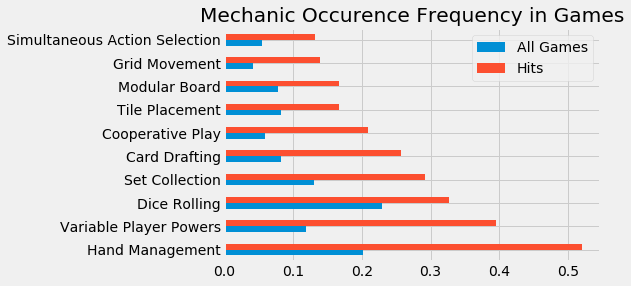

In [0]:
mech_freq = counts(general_mechanics,popular_mechanics).head(10)
mech_freq = mech_freq.rename(columns={'gen_count':'All Games',
                                      'pop_count':'Hits'})

plt.style.use('fivethirtyeight')

mech_freq.plot.barh(title='Mechanic Occurence Frequency in Games');

plt.savefig('mechanic_occurence_frequency.png', format='png', 
            dpi=300, bbox_inches='tight')
files.download('mechanic_occurence_frequency.png')

###Designers

In [0]:
designers = get_csv('designers_all.csv')
(general_designers, designers_by_game, games['designer_count'] 
                                                 = support_variables(designers))
popular_designers = popular_items(designers_by_game)
counts(general_designers,popular_designers).head(10)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (3,4,5,7,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,34,36,37,38,39,41,42,43,44,46,47,48,49,50,51,53,54,56,57,58,59,61,63,64,65,66,67,68,69,70,71,75,76,77,79,80,82,85,86,87,88,90,91,92,93,95,96,97,99,101,102,103,109,110,112,113,114,115,116,117,118,119,120,121,123,124,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,147,149,150,151,152,153,155,156,157,158,161,162,164,165,166,167,168,169,170,171,172,173,175,177,178,180,181,182,185,186,187,189,192,193,194,195,196,197,198,200,201,202,203,204,205,207,208,209,211,213,214,215,217,218,220,222,223,225,226,227,229,230,231,232,233,234,237,241,242,243,244,245,246,249,250,251,252,253,256,257,259,260,261,262,264,265,266,267,268,269,270,271,272,273,274,276,278,279,280,283,284,285,286,287,288,289,291,292,294,295,296,297,299,300,301,302,303,305,306,307,308,309,310,311,312,314,315,316,317,319,320,321,323

gen_count  pop_count
Antoine Bauza      0.001980   0.041667
Corey Konieczka    0.001398   0.041667
Uwe Rosenberg      0.002854   0.034722
Kevin Wilson       0.001864   0.027778
Bruno Cathala      0.004019   0.027778
Vlaada Chvátil     0.001689   0.027778
Richard Garfield   0.001631   0.027778
Matt Leacock       0.000990   0.027778
Ted Alspach        0.001922   0.020833
Reiner Knizia      0.014911   0.020833

In [0]:
designer_bat_avg = batting_average(popular_designers, general_designers)
designer_bat_avg.index.name = 'Designer'
designer_bat_avg[designer_bat_avg['Total Games']>=10].head(10)

Batting Avg  Hits  Total Games
Designer                                           
Corey Konieczka         0.250000   6.0         24.0
Matt Leacock            0.235294   4.0         17.0
Donald X. Vaccarino     0.187500   3.0         16.0
Antoine Bauza           0.176471   6.0         34.0
Alexander Pfister       0.142857   2.0         14.0
Richard Garfield        0.142857   4.0         28.0
Vlaada Chvátil          0.137931   4.0         29.0
Kevin Wilson            0.125000   4.0         32.0
Ignacy Trzewiczek       0.117647   2.0         17.0
Phil Walker-Harding     0.117647   2.0         17.0

###Artists

In [0]:
artists = get_csv('artists_all.csv')
(general_artists, artists_by_game, games['artist_count'] 
                                                   = support_variables(artists))
popular_artists = popular_items(artists_by_game)
counts(general_artists,popular_artists).head(10)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,2,5,6,9,12,13,14,21,23,26,28,30,31,32,34,37,41,43,46,47,51,52,53,54,57,60,63,64,65,66,67,69,70,71,72,74,77,80,82,83,88,89,90,91,94,97,99,101,102,104,106,108,109,111,112,114,117,118,119,121,130,134,135,139,141,144,145,146,147,149,151,152,153,154,155,156,157,159,160,161,162,163,165,166,167,168,169,170,171,173,174,175,177,181,182,183,184,185,187,188,190,191,192,195,197,199,200,201,202,203,206,207,209,211,213,214,215,216,217,219,221,222,229,232,235,237,238,239,241,242,243,245,246,247,251,253,257,260,261,263,264,269,270,271,273,274,276,278,279,282,283,284,286,289,291,300,308,311,312,315,316,318,321,322,323,325,326,329,331,333,334,335,337,338,339,341,342,345,347,349,352,353,357,359,360,361,362,363,364,370,374,376,378,379,380,382,383,384,385,386,388,391,392,393,394,396,398,399,400,404,406,407,409,410,411,415,416,421,428,429,432,435,436,437,438,442,443,444,447,448,449,450,451,453,454,455,456,

gen_count  pop_count
Franz Vohwinkel     0.012523   0.083333
Henning Ludvigsen   0.002039   0.069444
Harald Lieske       0.005184   0.055556
Julien Delval       0.002388   0.055556
Klemens Franz       0.005126   0.048611
Cyrille Daujean     0.001980   0.041667
Michael Menzel      0.006466   0.034722
Dallas Mehlhoff     0.000524   0.034722
Claus Stephan       0.005068   0.034722
Chris Quilliams     0.002272   0.034722

In [0]:
artist_batting_avg = batting_average(popular_artists, general_artists)
artist_batting_avg.index.name = 'Artist'
artist_batting_avg[artist_batting_avg['Total Games']>=30].head(10)

Batting Avg  Hits  Total Games
Henning Ludvigsen     0.285714  10.0         35.0
Julien Delval         0.195122   8.0         41.0
Cyrille Daujean       0.176471   6.0         34.0
Michaela Kienle       0.129032   4.0         31.0
Chris Quilliams       0.128205   5.0         39.0
Brian Schomburg       0.125000   5.0         40.0
Miguel Coimbra        0.102564   4.0         39.0
Martin Hoffmann       0.096774   3.0         31.0
Harald Lieske         0.089888   8.0         89.0
Dennis Lohausen       0.081967   5.0         61.0

###Categories

In [0]:
categories = get_csv('categories_all.csv')
(general_categories, categories_by_game, games['category_count'] 
                                                = support_variables(categories))
popular_categories = popular_items(categories_by_game)
counts(general_categories,popular_categories).head(10)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


gen_count  pop_count
Card Game         0.288793   0.361111
Fantasy           0.117486   0.243056
Fighting          0.077528   0.201389
Science Fiction   0.077586   0.152778
Adventure         0.050384   0.152778
Economic          0.072519   0.145833
Bluffing          0.058889   0.118056
Party Game        0.084751   0.111111
Medieval          0.048521   0.104167
Deduction         0.049569   0.104167

In [0]:
category_bat_avg = batting_average(popular_categories, general_categories)
category_bat_avg.index.name = 'Category'
category_bat_avg.head(10)

Batting Avg  Hits  Total Games
Space Exploration       0.043902   9.0        205.0
Farming                 0.042328   8.0        189.0
Spies/Secret Agents     0.038710   6.0        155.0
Territory Building      0.035264  14.0        397.0
Civilization            0.034965  10.0        286.0
City Building           0.034642  15.0        433.0
Medical                 0.031746   2.0         63.0
Zombies                 0.027933   5.0        179.0
Arabian                 0.025974   2.0         77.0
Adventure               0.025434  22.0        865.0

###Subdomains

In [0]:
subdomains = get_csv('subdomains_all.csv')
(general_subdomains, subdomains_by_game, games['subdomain_count'] 
                                                = support_variables(subdomains))
popular_subdomains = popular_items(subdomains_by_game)
counts(general_subdomains,popular_subdomains).head(10)

gen_count  pop_count
Strategy Games       0.111370   0.409722
Family Games         0.105312   0.347222
Thematic Games       0.060345   0.243056
Party Games          0.030231   0.118056
Abstract Games       0.055801   0.062500
Customizable Games   0.016368   0.034722
Wargames             0.171890   0.020833
Children's Games     0.044443        NaN

In [0]:
subdomain_bat_avg = batting_average(popular_subdomains, general_subdomains)
subdomain_bat_avg.index.name = 'Subdomain'
subdomain_bat_avg.head(10)

Batting Avg  Hits  Total Games
Thematic Games         0.033784  35.0       1036.0
Party Games            0.032755  17.0        519.0
Strategy Games         0.030858  59.0       1912.0
Family Games           0.027655  50.0       1808.0
Customizable Games     0.017794   5.0        281.0
Abstract Games         0.009395   9.0        958.0
Wargames               0.001017   3.0       2951.0
Children's Games            NaN   NaN        763.0

###Publishers

In [0]:
publishers = get_csv('publishers_all.csv')
(general_publishers, publishers_by_game, games['publisher_count'] 
                                                = support_variables(publishers))
popular_publishers = popular_items(publishers_by_game)
counts(general_publishers,popular_publishers).head(10)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

gen_count  pop_count
Kaissa Chess & Games         0.014504   0.326389
Hobby World                  0.017649   0.312500
Edge Entertainment           0.021901   0.298611
Devir                        0.017766   0.284722
Korea Boardgames co., Ltd.   0.009844   0.256944
Asmodee                      0.025221   0.250000
Galápagos Jogos              0.006466   0.250000
Rebel                        0.015261   0.243056
Gém Klub Kft.                0.006699   0.243056
Hobby Japan                  0.015610   0.243056

In [0]:
publisher_bat_avg = batting_average(popular_publishers, general_publishers)
publisher_bat_avg.index.name = 'Publisher'
publisher_bat_avg[publisher_bat_avg['Total Games']>=300].head(10)

Batting Avg  Hits  Total Games
Publisher                                                
Hobby World                   0.148515  45.0        303.0
Devir                         0.134426  41.0        305.0
Edge Entertainment            0.114362  43.0        376.0
Heidelberger Spieleverlag     0.093093  31.0        333.0
999 Games                     0.086514  34.0        393.0
Asmodee                       0.083141  36.0        433.0
Pegasus Spiele                0.065789  25.0        380.0
Rio Grande Games              0.049351  19.0        385.0
AMIGO                         0.022876   7.0        306.0
KOSMOS                        0.019444   7.0        360.0

#Exploration and Analysis

##Focused on Bayes Rating
My first route for exploration was based around the [`bayes_rating`](https://boardgamegeek.com/wiki/page/ratings), a weighted average of `rating`, with the assumption that great games were what sold. The first step in this process is to simply get a feel for the data.

In [0]:
games.head()

name   owned  bayes_rating  weight  avg_play_time   age  \
id                                                                      
13           Catan  123608       7.04016  2.3412          120.0  10.0   
822    Carcassonne  120110       7.32325  1.9259           45.0   8.0   
30549     Pandemic  121076       7.54713  2.4230           45.0   8.0   
68448    7 Wonders   89740       7.69094  2.3406           30.0  10.0   
36218     Dominion   87899       7.54537  2.3632           30.0  13.0   

       best_with_dense  spinoffs  lang_dependance  comment_count  honor_count  \
id                                                                              
13                   4        31              2.0          16207         13.0   
822                  2        25              1.0          16078         12.0   
30549                4         8              2.0          13977         34.0   
68448                4         1              1.0          11723         50.0   
36218                3         8              3.0          12115         41.0   

       publish_date  best_age  max_play_time  min_play_time  play_time_range  \
id                                                                             
13             1995       5.0          120.0           60.0             60.0   
822            2000       5.0           45.0           30.0             15.0   
30549          2008       6.0           45.0           45.0              0.0   
68448          2010       6.0           30.0           30.0              0.0   
36218          2008       6.0           30.0           30.0              0.0   

       max_players  min_players best_with  player_range  rating_votes  \
id                                                                      
13             4.0          3.0       4.0           1.0         84363   
822            5.0          2.0       2.0           3.0         84045   
30549          4.0          2.0       4.0           2.0         82331   
68448          7.0          2.0       4.0           5.0         68249   
36218          4.0          2.0       3.0           2.0         67698   

       weight_votes  trading  wanting  wishing   rating  std_dev  weight_rnd  \
id                                                                             
13             6844     1652      451     4699  7.19430  1.46985         2.0   
822            6924     1461      498     5337  7.42741  1.30276         2.0   
30549          4854     1935      622     7610  7.64064  1.32187         2.0   
68448          3984     1144     1025     9407  7.78348  1.27550         2.0   
36218          4669     1791      564     6621  7.64685  1.42680         2.0   

                                             description  \
id                                                         
13     In Catan (formerly The Settlers of Catan), pla...   
822    Carcassonne is a tile-placement game in which ...   
30549  In Pandemic, several virulent diseases have br...   
68448  You are the leader of one of the 7 great citie...   
36218  (from the back of the box:)<br/><br/>&quot;You...   

                                                   image  
id                                                        
13     https://cf.geekdo-images.com/original/img/A-0y...  
822    https://cf.geekdo-images.com/original/img/o4p6...  
30549  https://cf.geekdo-images.com/original/img/j-pf...  
68448  https://cf.geekdo-images.com/original/img/3DP_...  
36218  https://cf.geekdo-images.com/original/img/oN8C...

In [0]:
games.describe()

owned  bayes_rating        weight  avg_play_time           age  \
count   17168.000000  17168.000000  16857.000000   16735.000000  16043.000000   
mean     1254.187733      5.700732      2.045228      99.703615     10.204014   
std      4234.644828      0.381683      0.802993    1093.475337      2.721674   
min         3.000000      3.465090      1.000000       1.000000      1.000000   
25%       143.000000      5.511828      1.368400      30.000000      8.000000   
50%       298.000000      5.556935      2.000000      45.000000     10.000000   
75%       804.250000      5.706898      2.583300      90.000000     12.000000   
max    123608.000000      8.611030      5.000000  120000.000000     25.000000   

       best_with_dense      spinoffs  lang_dependance  comment_count  \
count     17168.000000  17168.000000     12126.000000   17168.000000   
mean          2.670608      0.506990         2.048326     202.547880   
std           1.806545      2.504742         1.221312     609.012033   
min           0.000000     -1.000000         1.000000       1.000000   
25%           2.000000      0.000000         1.000000      24.000000   
50%           2.000000      0.000000         2.000000      50.000000   
75%           4.000000      0.000000         3.000000     133.000000   
max          31.000000    123.000000         5.000000   16207.000000   

        honor_count  publish_date     best_age  max_play_time  min_play_time  \
count  17168.000000  17168.000000  12183.00000   16657.000000   16720.000000   
mean       0.493418   1983.910123      5.70229      99.995257      72.398026   
std        1.697302    207.195949      1.71455    1096.022936     509.489871   
min        0.000000  -3500.000000      1.00000       1.000000       1.000000   
25%        0.000000   1999.000000      5.00000      30.000000      20.000000   
50%        0.000000   2009.000000      6.00000      45.000000      40.000000   
75%        0.000000   2015.000000      7.00000      90.000000      60.000000   
max       50.000000   2020.000000     11.00000  120000.000000   60000.000000   

       play_time_range   max_players   min_players  player_range  \
count     16642.000000  16987.000000  17102.000000  16977.000000   
mean         27.479389      5.601401      2.048181      3.557107   
std         963.422456     15.832166      0.667624     15.797476   
min           0.000000      1.000000      1.000000      0.000000   
25%           0.000000      4.000000      2.000000      1.000000   
50%           0.000000      4.000000      2.000000      2.000000   
75%           0.000000      6.000000      2.000000      4.000000   
max      119880.000000    999.000000     10.000000    997.000000   

       rating_votes  weight_votes       trading       wanting       wishing  \
count  17168.000000  17168.000000  17168.000000  17168.000000  17168.000000   
mean     767.870573     52.786172     42.100944     42.775047    195.281454   
std     3033.164942    206.021538     93.456338    118.737475    632.689892   
min       30.000000      0.000000      0.000000      0.000000      0.000000   
25%       55.000000      5.000000      5.000000      3.000000     12.000000   
50%      118.000000     10.000000     14.000000      9.000000     34.000000   
75%      371.000000     29.000000     39.000000     29.000000    113.000000   
max    84363.000000   6924.000000   2223.000000   2080.000000  13136.000000   

             rating       std_dev    weight_rnd  
count  17168.000000  17168.000000  16857.000000  
mean       6.362220      1.507242      2.034882  
std        0.917319      0.277478      0.863057  
min        1.052540      0.219673      1.000000  
25%        5.785507      1.316905      1.000000  
50%        6.392880      1.470580      2.000000  
75%        6.971192      1.649275      3.000000  
max        9.597140      4.068800      5.000000

In [0]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17168 entries, 13 to 270109
Data columns (total 36 columns):
name               17168 non-null object
owned              17168 non-null int64
bayes_rating       17168 non-null float64
weight             16857 non-null float64
avg_play_time      16735 non-null float64
age                16043 non-null float64
best_with_dense    17168 non-null int64
spinoffs           17168 non-null int64
lang_dependance    12126 non-null float64
comment_count      17168 non-null int64
honor_count        17168 non-null float64
publish_date       17168 non-null int64
best_age           12183 non-null float64
max_play_time      16657 non-null float64
min_play_time      16720 non-null float64
play_time_range    16642 non-null float64
max_players        16987 non-null float64
min_players        17102 non-null float64
best_with          17168 non-null object
player_range       16977 non-null float64
rating_votes       17168 non-null int64
weight_votes       17

In [0]:
games.shape

(17168, 36)

Next I take a look at what is visually occuring in the data by graphing it.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


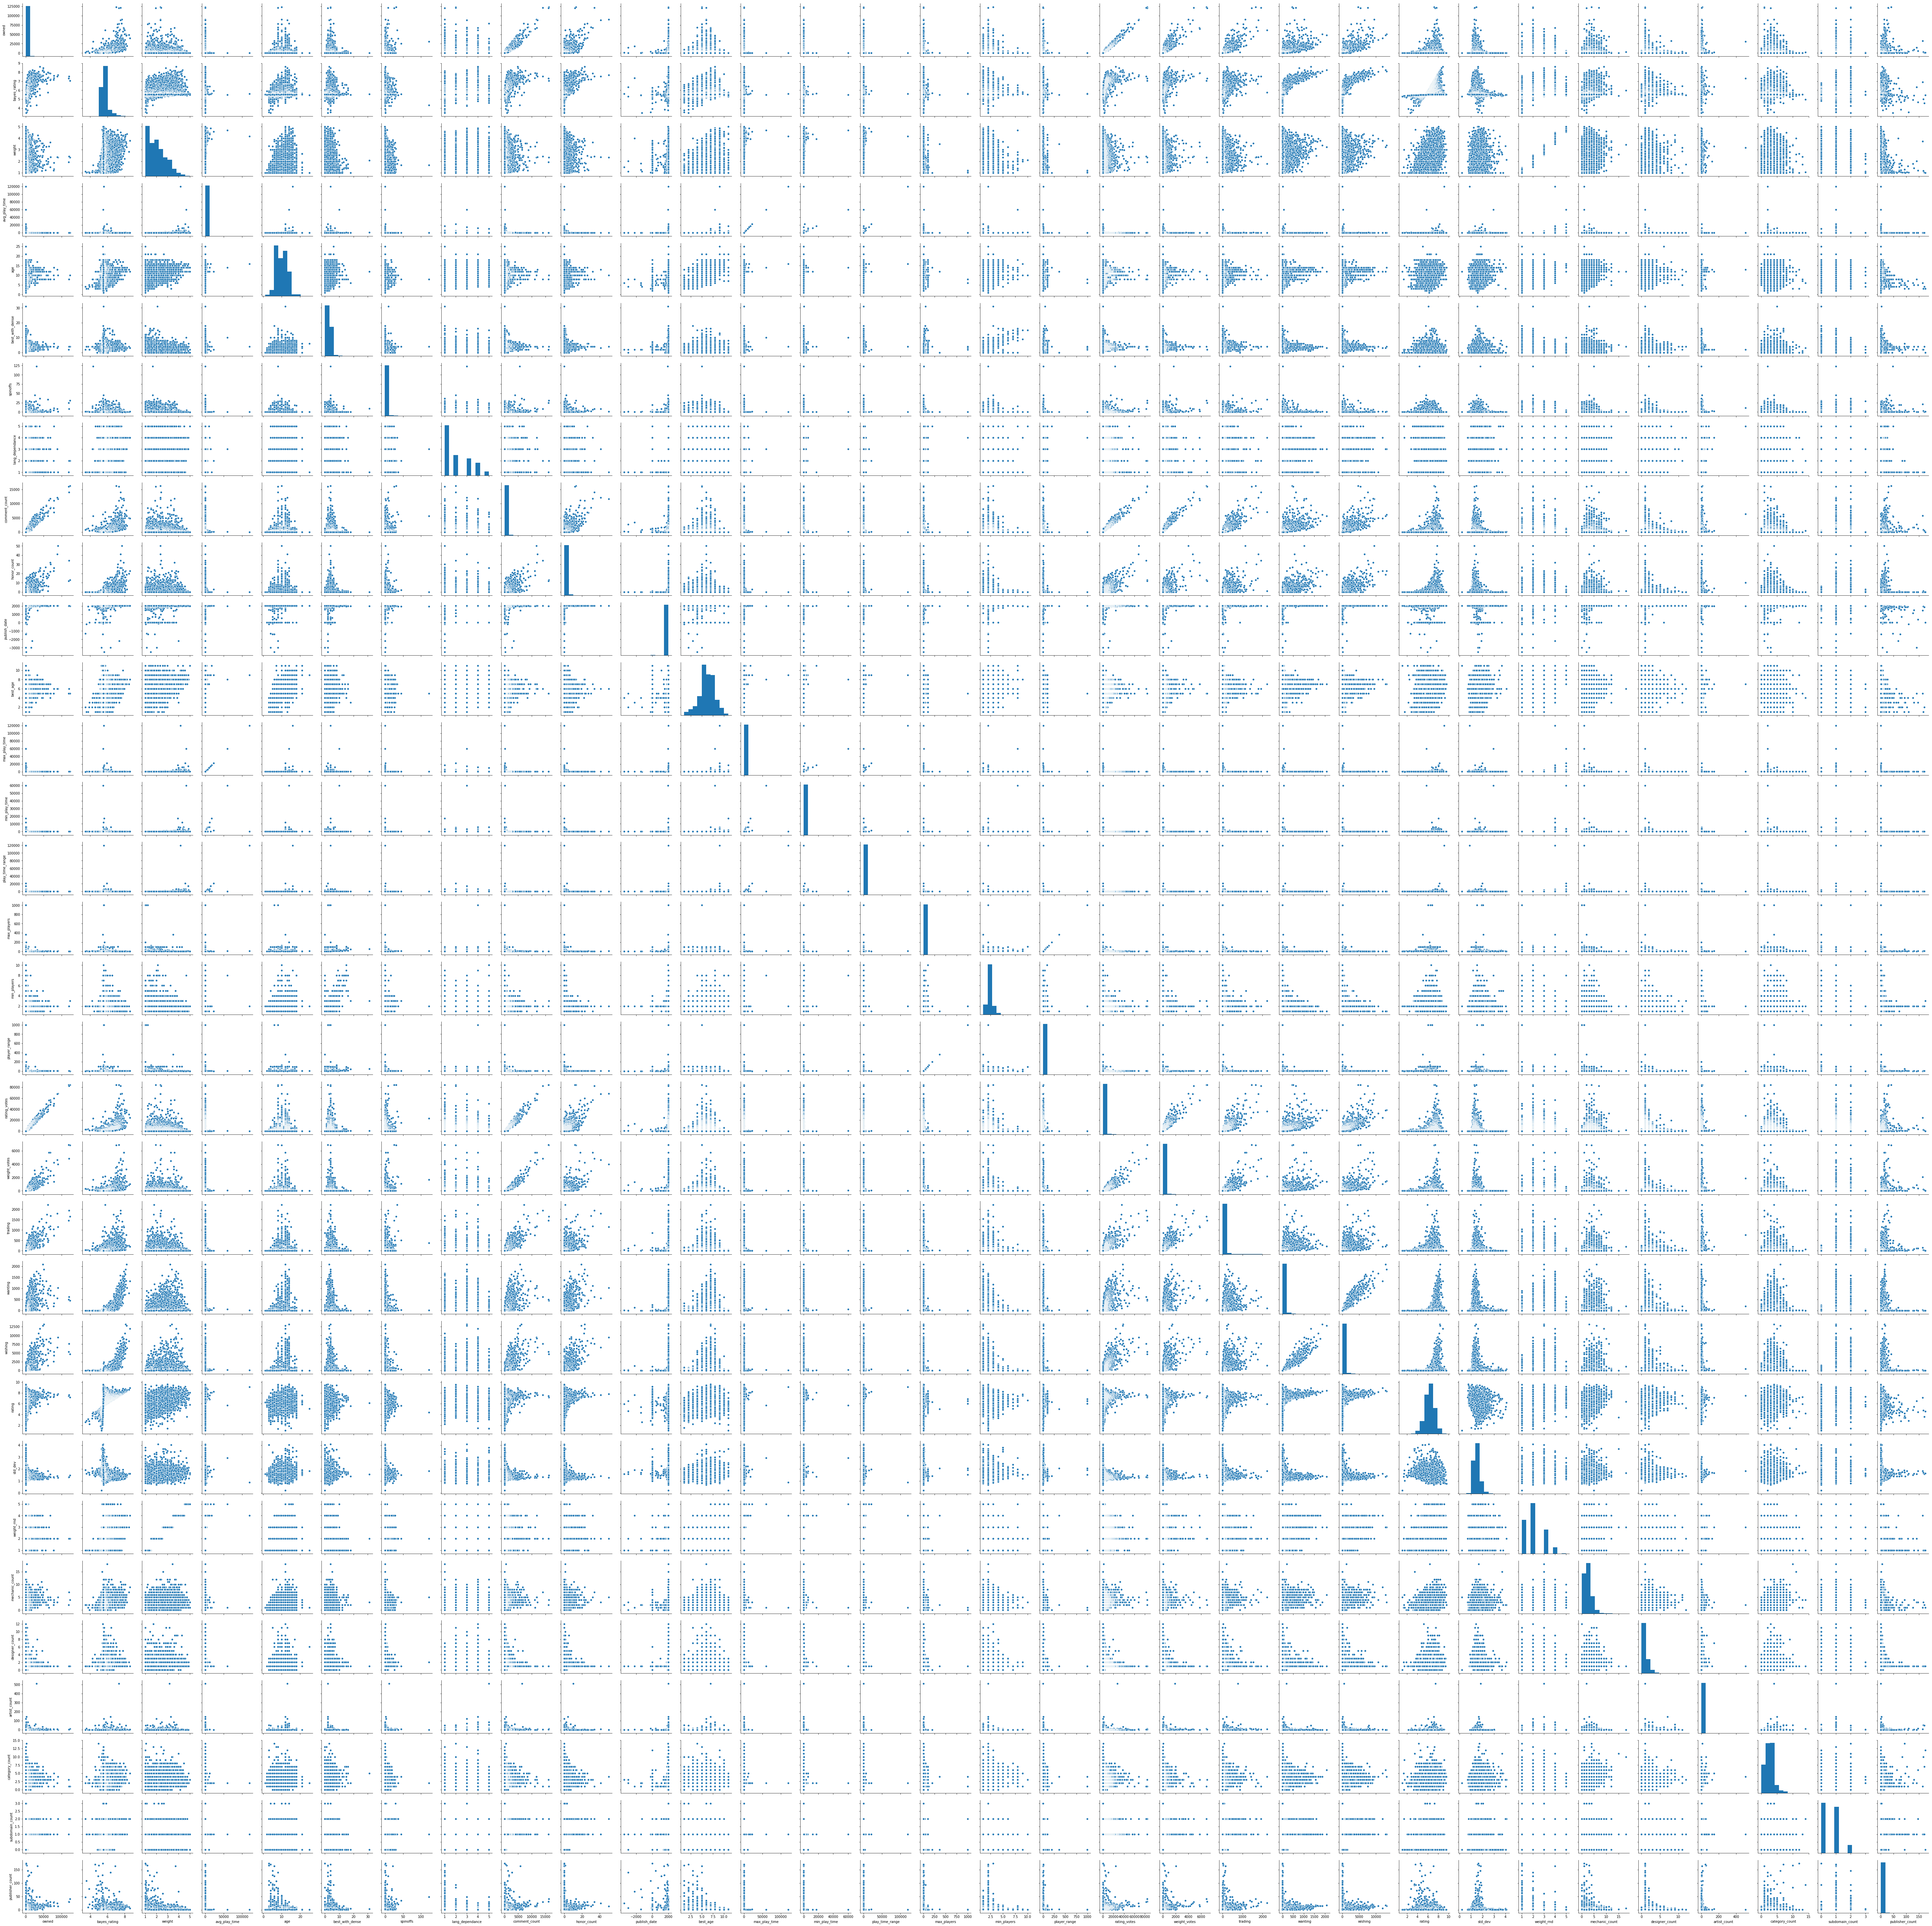

In [0]:
#Using the shotgun approach to graphing, looking for any unexpected graph shapes
#Noticing that some of my features report nearly the same thing, such as:
#`wanting`, `wishing`, and `trading`.
sns.pairplot(games);

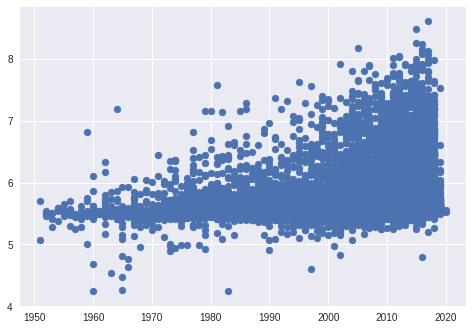

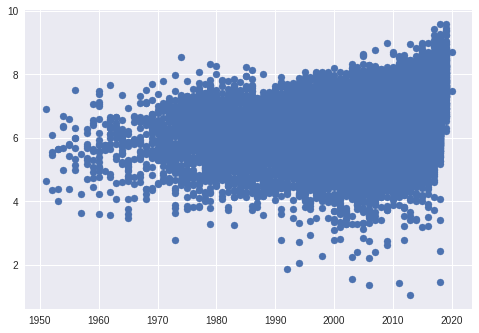

In [0]:
#confirming my decision to use `bayes_rating` over `rating`.
#`bayes_rating` reduces the impact of early votes so you don't...
#have outliers caused by low vote count
plt.scatter(games[games['publish_date']>1950]['publish_date'], 
            games[games['publish_date']>1950]['bayes_rating']);
plt.show()
plt.scatter(games[games['publish_date']>1950]['publish_date'], 
            games[games['publish_date']>1950]['rating']);

In [0]:
#preparing to make some cross tabs and pivot tables
rating_bins = pd.cut(games['bayes_rating'],15)
age_bins = pd.cut(games[games['age']<=18]['age'],bins=[0,4,7,9,11,13,16,26])
playtime_bins = pd.cut(games[games['avg_play_time']<240]['avg_play_time'],5)
weight_bins = pd.cut(games['weight'],5)

In [0]:
#what ages are games made for?
games['age'].value_counts().sort_index()

1.0        1
2.0        9
3.0      101
4.0      219
5.0      366
6.0      742
7.0      654
8.0     3405
9.0      295
10.0    3312
11.0      83
12.0    4207
13.0     973
14.0    1238
15.0     127
16.0     122
17.0      38
18.0     142
21.0       8
25.0       1
Name: age, dtype: int64

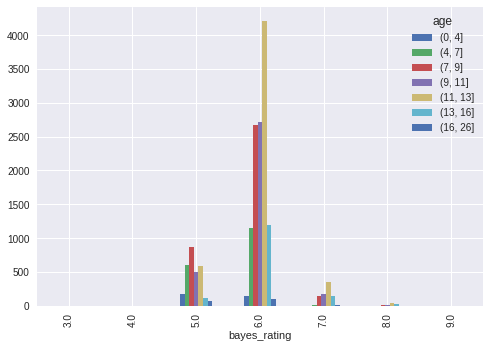

In [0]:
#how many games are made for each age broken out by rating
#games are made for 10-12 year olds to be able to play them, not surprising
pd.crosstab(age_bins,games['bayes_rating'].round()).T.plot.bar();

In [0]:
#Rating and play time
#A vast majority of mediocre games are short
pd.crosstab(rating_bins,playtime_bins)

avg_play_time   (0.779, 45.2]  (45.2, 89.4]  (89.4, 133.6]  (133.6, 177.8]  \
bayes_rating                                                                 
(3.46, 3.808]               3             0              0               0   
(3.808, 4.151]              1             1              0               0   
(4.151, 4.494]              3             1              0               0   
(4.494, 4.837]             17             0              0               0   
(4.837, 5.18]              29             7              4               0   
(5.18, 5.523]            3453           819            671              13   
(5.523, 5.867]           4422          1384           1417              67   
(5.867, 6.21]             600           288            272              16   
(6.21, 6.553]             294           154            158               8   
(6.553, 6.896]            156           101            105               7   
(6.896, 7.239]             78            62             79               5   
(7.239, 7.582]             26            27             58               1   
(7.582, 7.925]              7             5             19               7   
(7.925, 8.268]              1             0              8               3   
(8.268, 8.611]              0             1              1               0   

avg_play_time   (177.8, 222.0]  
bayes_rating                    
(3.46, 3.808]                0  
(3.808, 4.151]               0  
(4.151, 4.494]               1  
(4.494, 4.837]               0  
(4.837, 5.18]                0  
(5.18, 5.523]              127  
(5.523, 5.867]             420  
(5.867, 6.21]               71  
(6.21, 6.553]               34  
(6.553, 6.896]              24  
(6.896, 7.239]              19  
(7.239, 7.582]              13  
(7.582, 7.925]               4  
(7.925, 8.268]               2  
(8.268, 8.611]               0

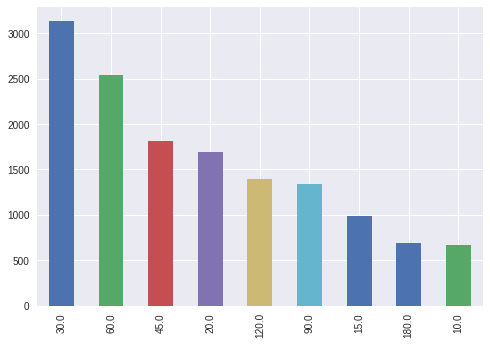

In [0]:
#How many games at each time interval
#60minutes with a surpisingly strong 2nd place showing
games['avg_play_time'].value_counts()[:10].plot.bar();

In [0]:
#rating and language dependance
#better games have more reliance on text
pd.crosstab(games['bayes_rating'].round(),games['lang_dependance'],normalize='columns')

lang_dependance       1.0       2.0       3.0       4.0       5.0
bayes_rating                                                     
3.0              0.000172  0.000000  0.000000  0.000000  0.000000
4.0              0.001204  0.000000  0.001014  0.000000  0.000000
5.0              0.149837  0.142436  0.118094  0.133559  0.302846
6.0              0.784793  0.791403  0.772428  0.753898  0.650407
7.0              0.058834  0.063211  0.099341  0.095593  0.040650
8.0              0.005161  0.002950  0.009123  0.016271  0.006098
9.0              0.000000  0.000000  0.000000  0.000678  0.000000

In [0]:
#looking at the really heavy games
games[games['weight'] >= 4].describe()

owned  bayes_rating      weight  avg_play_time         age  \
count    326.000000    326.000000  326.000000     313.000000  290.000000   
mean    1396.567485      5.890114    4.237267    1354.217252   12.693103   
std     3215.465552      0.557571    0.222600    7791.748128    1.252936   
min        7.000000      5.401420    4.000000      20.000000    9.000000   
25%      187.250000      5.569320    4.043450     180.000000   12.000000   
50%      398.000000      5.644920    4.200000     300.000000   12.000000   
75%      998.750000      5.936740    4.361975     360.000000   14.000000   
max    34039.000000      8.258050    5.000000  120000.000000   17.000000   

       best_with_dense    spinoffs  lang_dependance  comment_count  \
count       326.000000  326.000000       213.000000     326.000000   
mean          2.527607    0.168712         2.737089     238.107362   
std           1.612692    0.858838         1.279882     548.737940   
min           0.000000   -1.000000         1.000000       1.000000   
25%           2.000000    0.000000         2.000000      32.000000   
50%           2.000000    0.000000         3.000000      65.000000   
75%           4.000000    0.000000         4.000000     160.750000   
max          10.000000    6.000000         5.000000    4896.000000   

       honor_count  publish_date    best_age  max_play_time  min_play_time  \
count   326.000000    326.000000  243.000000     311.000000     313.000000   
mean      0.880368   2002.880368    8.078189    1362.540193     600.814696   
std       1.704595     13.272799    0.934894    7816.146686    3514.290933   
min       0.000000   1936.000000    5.000000      20.000000      10.000000   
25%       0.000000   1994.250000    8.000000     180.000000     120.000000   
50%       0.000000   2005.000000    8.000000     300.000000     180.000000   
75%       1.000000   2015.000000    9.000000     360.000000     360.000000   
max      11.000000   2019.000000   11.000000  120000.000000   60000.000000   

       play_time_range  max_players  min_players  player_range  rating_votes  \
count       311.000000   322.000000   325.000000    322.000000    326.000000   
mean        758.247588     4.819876     1.827692      2.990683    808.806748   
std        6985.545726     7.784791     0.658165      7.791075   2493.400434   
min           0.000000     1.000000     1.000000      0.000000     30.000000   
25%           0.000000     2.000000     1.000000      0.000000     56.000000   
50%           0.000000     4.000000     2.000000      2.000000    124.000000   
75%          60.000000     6.000000     2.000000      4.000000    325.000000   
max      119880.000000    99.000000     8.000000     98.000000  23305.000000   

       weight_votes     trading      wanting      wishing      rating  \
count    326.000000  326.000000   326.000000   326.000000  326.000000   
mean      85.223926   36.904908   100.392638   434.714724    7.447080   
std      228.498609   88.247625   205.408799  1084.109635    0.792893   
min        1.000000    0.000000     0.000000     1.000000    3.596830   
25%        9.000000    5.000000    13.000000    34.000000    7.014050   
50%       19.000000   11.000000    32.000000    79.500000    7.487275   
75%       57.750000   33.750000    74.750000   218.250000    7.993468   
max     2100.000000  857.000000  1360.000000  9022.000000    9.230340   

          std_dev  
count  326.000000  
mean     1.655160  
std      0.316816  
min      0.836193  
25%      1.454450  
50%      1.613400  
75%      1.797958  
max      3.500490

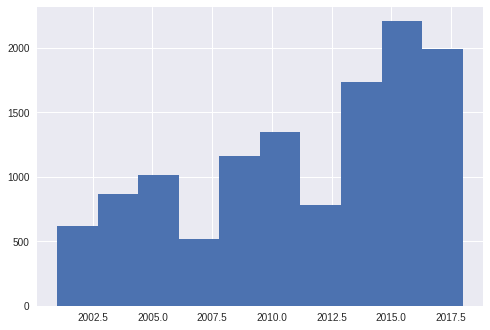

In [0]:
#look at when games were published in the last 20 years
#those dips are interesting
games[(games['publish_date']>2000) & 
      (games['publish_date']<2019)]['publish_date'].hist();

In [0]:
#mid 2000's, modern board games began picking up steam, 2014 starts the peak
games[(games['publish_date']>2000) & 
      (games['publish_date']<2019)]['publish_date'].value_counts().sort_index()

2001     294
2002     322
2003     395
2004     472
2005     524
2006     494
2007     515
2008     556
2009     602
2010     660
2011     689
2012     780
2013     806
2014     929
2015    1065
2016    1143
2017    1091
2018     899
Name: publish_date, dtype: int64

In [0]:
#some interesting fits of growth but overall a steady climb until the 2000's
games[games['publish_date']>1950]['publish_date'].value_counts().sort_index(
                                                                ascending=False)

2020       2
2019     134
2018     899
2017    1091
2016    1143
2015    1065
2014     929
2013     806
2012     780
2011     689
2010     660
2009     602
2008     556
2007     515
2006     494
2005     524
2004     472
2003     395
2002     322
2001     294
2000     278
1999     262
1998     232
1997     216
1996     203
1995     211
1994     170
1993     173
1992     193
1991     165
1990     139
1989     124
1988     124
1987     126
1986     144
1985     125
1984      91
1983     113
1982     115
1981     144
1980     116
1979     128
1978      90
1977      99
1976      63
1975     113
1974      64
1973      67
1972      67
1971      36
1970      32
1969      25
1968      21
1967      19
1966      11
1965      24
1964      19
1963      14
1962      17
1961      10
1960      20
1959      11
1958       9
1957       3
1956       8
1955       5
1954       5
1953       4
1952       4
1951       2
Name: publish_date, dtype: int64

In [0]:
#is there nostalgia or a desire for the new?
#mediocrity improves but not much gain on the high end
pd.crosstab(games['bayes_rating'].round(),
            games[(games['publish_date']>2000) & (games['publish_date']<2019)]
            ['publish_date'], normalize='columns')

publish_date      2001      2002      2003      2004      2005      2006  \
bayes_rating                                                               
5.0           0.275510  0.257764  0.286076  0.258475  0.263359  0.246964   
6.0           0.680272  0.717391  0.683544  0.680085  0.681298  0.714575   
7.0           0.044218  0.021739  0.030380  0.059322  0.049618  0.036437   
8.0           0.000000  0.003106  0.000000  0.002119  0.005725  0.002024   
9.0           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

publish_date      2007      2008      2009      2010      2011      2012  \
bayes_rating                                                               
5.0           0.260194  0.179856  0.182724  0.122727  0.136430  0.126923   
6.0           0.675728  0.773381  0.744186  0.810606  0.772134  0.787179   
7.0           0.058252  0.039568  0.071429  0.062121  0.084180  0.074359   
8.0           0.005825  0.007194  0.001661  0.004545  0.007257  0.011538   
9.0           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

publish_date      2013      2014      2015      2016      2017      2018  
bayes_rating                                                              
5.0           0.121588  0.107643  0.080751  0.068241  0.034830  0.016685  
6.0           0.813896  0.796555  0.830986  0.858268  0.886343  0.931034  
7.0           0.059553  0.087191  0.076995  0.064742  0.069661  0.048943  
8.0           0.004963  0.008611  0.011268  0.008749  0.008249  0.003337  
9.0           0.000000  0.000000  0.000000  0.000000  0.000917  0.000000

##Exploring `Owned` as a Measure of Popularity
Realized I was over looking an obvious metric of popularity thanks to my own bias with gaming. What is rated the best doesn't necessarily sell the most.

In [0]:
#top 1% of games
most_popular = games.sort_values(by=['owned'],ascending=False).head(172)

In [0]:
#immediately see all the familiar faces, staples of the hobby
most_popular.head()

name   owned  bayes_rating  weight  avg_play_time   age  \
id                                                                      
13           Catan  123608       7.04016  2.3412          120.0  10.0   
30549     Pandemic  121076       7.54713  2.4230           45.0   8.0   
822    Carcassonne  120110       7.32325  1.9259           45.0   8.0   
68448    7 Wonders   89740       7.69094  2.3406           30.0  10.0   
36218     Dominion   87899       7.54537  2.3632           30.0  13.0   

       best_with_dense  spinoffs  lang_dependance  comment_count  honor_count  \
id                                                                              
13                   4        31              2.0          16207         13.0   
30549                4         8              2.0          13977         34.0   
822                  2        25              1.0          16078         12.0   
68448                4         1              1.0          11723         50.0   
36218                3         8              3.0          12115         41.0   

       publish_date  best_age  max_play_time  min_play_time  play_time_range  \
id                                                                             
13             1995       5.0          120.0           60.0             60.0   
30549          2008       6.0           45.0           45.0              0.0   
822            2000       5.0           45.0           30.0             15.0   
68448          2010       6.0           30.0           30.0              0.0   
36218          2008       6.0           30.0           30.0              0.0   

       max_players  min_players best_with  player_range  rating_votes  \
id                                                                      
13             4.0          3.0       4.0           1.0         84363   
30549          4.0          2.0       4.0           2.0         82331   
822            5.0          2.0       2.0           3.0         84045   
68448          7.0          2.0       4.0           5.0         68249   
36218          4.0          2.0       3.0           2.0         67698   

       weight_votes  trading  wanting  wishing   rating  std_dev  weight_rnd  \
id                                                                             
13             6844     1652      451     4699  7.19430  1.46985         2.0   
30549          4854     1935      622     7610  7.64064  1.32187         2.0   
822            6924     1461      498     5337  7.42741  1.30276         2.0   
68448          3984     1144     1025     9407  7.78348  1.27550         2.0   
36218          4669     1791      564     6621  7.64685  1.42680         2.0   

                                             description  \
id                                                         
13     In Catan (formerly The Settlers of Catan), pla...   
30549  In Pandemic, several virulent diseases have br...   
822    Carcassonne is a tile-placement game in which ...   
68448  You are the leader of one of the 7 great citie...   
36218  (from the back of the box:)<br/><br/>&quot;You...   

                                                   image  
id                                                        
13     https://cf.geekdo-images.com/original/img/A-0y...  
30549  https://cf.geekdo-images.com/original/img/j-pf...  
822    https://cf.geekdo-images.com/original/img/o4p6...  
68448  https://cf.geekdo-images.com/original/img/3DP_...  
36218  https://cf.geekdo-images.com/original/img/oN8C...

In [0]:
#top games of the modern era, choosing 1990 to be conservative
#this should give a better look at what current trends are
#I love Chess and Go but they don't predict the next Catan
modern_hits = most_popular[most_popular['publish_date'] > 1990]
modern_hits.describe()

owned  bayes_rating      weight  avg_play_time         age  \
count     158.000000    158.000000  158.000000     158.000000  158.000000   
mean    34629.208861      7.251453    2.361918      74.000000   10.993671   
std     19579.185575      0.555160    0.836215      59.373373    2.333628   
min     17711.000000      5.576310    1.068500      10.000000    5.000000   
25%     22228.750000      6.936587    1.661925      30.000000    8.000000   
50%     27623.500000      7.286785    2.337850      60.000000   12.000000   
75%     40505.750000      7.628850    2.999350      90.000000   13.000000   
max    123608.000000      8.611030    4.364000     360.000000   17.000000   

       best_with_dense    spinoffs  lang_dependance  comment_count  \
count       158.000000  158.000000       158.000000     158.000000   
mean          3.873418    2.310127         2.303797    4697.962025   
std           1.295431    5.143671         1.255352    2608.155729   
min           1.000000   -1.000000         1.000000    1777.000000   
25%           3.000000    0.000000         1.000000    2947.750000   
50%           4.000000    1.000000         2.000000    3858.500000   
75%           4.000000    2.000000         3.000000    5562.000000   
max           7.000000   34.000000         5.000000   16207.000000   

       honor_count  publish_date    best_age  max_play_time  min_play_time  \
count    158.00000    158.000000  158.000000     158.000000     158.000000   
mean       9.93038   2009.044304    6.012658      74.000000      49.886076   
std        8.26636      6.013091    1.183686      59.373373      32.266994   
min        0.00000   1991.000000    3.000000      10.000000       5.000000   
25%        4.00000   2005.000000    5.000000      30.000000      30.000000   
50%        8.00000   2011.000000    6.000000      60.000000      45.000000   
75%       13.00000   2014.000000    7.000000      90.000000      60.000000   
max       50.00000   2017.000000    9.000000     360.000000     180.000000   

       play_time_range  max_players  min_players  player_range  rating_votes  \
count       158.000000   158.000000   158.000000    158.000000    158.000000   
mean         24.113924     5.955696     2.037975      3.917722  24866.829114   
std          40.457255     7.961968     0.739134      7.883681  14122.739357   
min           0.000000     1.000000     1.000000      0.000000  11165.000000   
25%           0.000000     4.000000     2.000000      2.000000  15873.500000   
50%           0.000000     5.000000     2.000000      3.000000  20104.500000   
75%          30.000000     6.000000     2.000000      4.000000  27930.750000   
max         240.000000    99.000000     5.000000     97.000000  84363.000000   

       weight_votes      trading      wanting       wishing      rating  \
count    158.000000   158.000000   158.000000    158.000000  158.000000   
mean    1443.936709   622.829114   687.537975   4428.658228    7.407132   
std     1209.619041   381.838516   442.429290   2600.343485    0.571839   
min      138.000000   110.000000    38.000000    410.000000    5.683840   
25%      709.500000   343.000000   315.250000   2444.000000    7.065750   
50%     1080.000000   539.000000   595.000000   4215.500000    7.444760   
75%     1766.500000   765.250000   988.000000   6054.250000    7.767710   
max     6924.000000  2223.000000  2080.000000  13136.000000    8.906020   

          std_dev  weight_rnd  
count  158.000000  158.000000  
mean     1.373544    2.335443  
std      0.178616    0.921165  
min      1.102910    1.000000  
25%      1.246590    2.000000  
50%      1.355155    2.000000  
75%      1.465533    3.000000  
max      2.070430    4.000000

In [0]:
#all modern games
#comparing the hits to the unclean masses
games[games['publish_date']>1990].describe()

owned  bayes_rating        weight  avg_play_time           age  \
count   14475.000000  14475.000000  14179.000000   14119.000000  13528.000000   
mean     1337.253264      5.724553      2.031304      90.323182     10.238247   
std      4488.362464      0.395955      0.796337    1061.460960      2.735515   
min         3.000000      4.603830      1.000000       1.000000      1.000000   
25%       144.000000      5.516610      1.357100      30.000000      8.000000   
50%       308.000000      5.565520      2.000000      45.000000     10.000000   
75%       865.500000      5.738265      2.555600      90.000000     12.000000   
max    123608.000000      8.611030      5.000000  120000.000000     25.000000   

       best_with_dense      spinoffs  lang_dependance  comment_count  \
count     14475.000000  14475.000000     10553.000000   14475.000000   
mean          2.733955      0.381831         2.056856     210.287461   
std           1.793900      1.920318         1.219778     637.000156   
min           0.000000     -1.000000         1.000000       1.000000   
25%           2.000000      0.000000         1.000000      24.000000   
50%           3.000000      0.000000         2.000000      50.000000   
75%           4.000000      0.000000         3.000000     138.000000   
max          18.000000     34.000000         5.000000   16207.000000   

        honor_count  publish_date      best_age  max_play_time  min_play_time  \
count  14475.000000  14475.000000  10452.000000   14041.000000   14104.000000   
mean       0.549361   2009.199724      5.693264      90.617050      61.764039   
std        1.825682      7.188819      1.670968    1064.396256     188.230361   
min        0.000000   1991.000000      1.000000       1.000000       1.000000   
25%        0.000000   2005.000000      5.000000      30.000000      20.000000   
50%        0.000000   2011.000000      6.000000      45.000000      30.000000   
75%        0.000000   2015.000000      7.000000      90.000000      60.000000   
max       50.000000   2020.000000     11.000000  120000.000000   17280.000000   

       play_time_range   max_players   min_players  player_range  \
count     14026.000000  14346.000000  14442.000000  14336.000000   
mean         28.762299      5.725777      2.056571      3.674037   
std        1043.165158     16.730257      0.674646     16.697100   
min           0.000000      1.000000      1.000000      0.000000   
25%           0.000000      4.000000      2.000000      2.000000   
50%           0.000000      4.000000      2.000000      2.000000   
75%          10.000000      6.000000      2.000000      4.000000   
max      119880.000000    999.000000      9.000000    997.000000   

       rating_votes  weight_votes       trading       wanting      wishing  \
count  14475.000000  14475.000000  14475.000000  14475.000000  14475.00000   
mean     826.654093     54.616028     43.905976     47.650777    221.69361   
std     3227.962129    217.576682     97.308105    127.325294    680.85157   
min       30.000000      0.000000      0.000000      0.000000      0.00000   
25%       56.000000      4.000000      5.000000      3.000000     14.00000   
50%      125.000000     10.000000     14.000000     10.000000     41.00000   
75%      404.000000     29.000000     41.000000     33.000000    135.00000   
max    84363.000000   6924.000000   2223.000000   2080.000000  13136.00000   

             rating       std_dev    weight_rnd  
count  14475.000000  14475.000000  14179.000000  
mean       6.436590      1.498422      2.022428  
std        0.905562      0.283940      0.857158  
min        1.052540      0.219673      1.000000  
25%        5.864590      1.301865      1.000000  
50%        6.463330      1.455740      2.000000  
75%        7.042875      1.641395      3.000000  
max        9.597140      4.068800      5.000000

In [0]:
#more shotgunning
sns.pairplot(modern_hits)

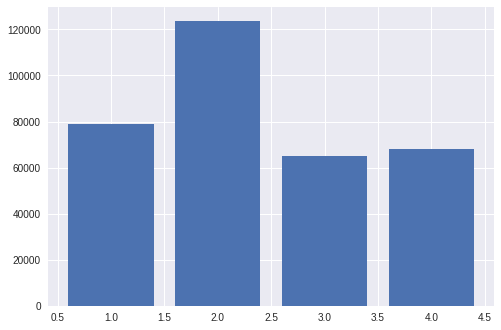

In [0]:
#owned by weight, 2 is the most popular by a decent margin
plt.bar(modern_hits['weight_rnd'],modern_hits['owned']);

In [0]:
#rough estimate of which years had the best selling games. 
#2012 and 2014 with the 1 and 2 spots
modern_hits.groupby('publish_date')['owned'].sum()

publish_date
1991     17837
1993     30342
1994     45352
1995    143859
1996     19650
1997    120979
1998     24755
1999     85183
2000    223688
2001    113392
2002     92244
2003     71749
2004    314855
2005    267430
2006     41255
2007    180803
2008    452829
2009    247534
2010    247098
2011    440059
2012    671321
2013    231626
2014    545079
2015    410061
2016    332257
2017    100178
Name: owned, dtype: int64

In [0]:
#how many hits each year
modern_hits['publish_date'].value_counts().sort_index()

1991     1
1993     1
1994     2
1995     2
1996     1
1997     4
1998     1
1999     3
2000     4
2001     3
2002     2
2003     3
2004     8
2005     8
2006     2
2007     5
2008    10
2009     6
2010     5
2011    14
2012    21
2013     8
2014    18
2015    12
2016    11
2017     3
Name: publish_date, dtype: int64

In [0]:
#Catan makes 95 king when broken down owned per game. 2000 and 2010 with 2 and 3
(modern_hits.groupby('publish_date')['owned'].sum())/(
                                     modern_hits['publish_date'].value_counts())

1991    17837.000000
1993    30342.000000
1994    22676.000000
1995    71929.500000
1996    19650.000000
1997    30244.750000
1998    24755.000000
1999    28394.333333
2000    55922.000000
2001    37797.333333
2002    46122.000000
2003    23916.333333
2004    39356.875000
2005    33428.750000
2006    20627.500000
2007    36160.600000
2008    45282.900000
2009    41255.666667
2010    49419.600000
2011    31432.785714
2012    31967.666667
2013    28953.250000
2014    30282.166667
2015    34171.750000
2016    30205.181818
2017    33392.666667
dtype: float64

In [0]:
#most games best with 4
modern_hits['best_with_dense'].value_counts().sort_index()

1     3
2    25
3    22
4    71
5    17
6    16
7     4
Name: best_with_dense, dtype: int64

In [0]:
#4 is still king
modern_hits['max_players'].value_counts().sort_index()

1.0      1
2.0     13
4.0     53
5.0     36
6.0     23
7.0      7
8.0     14
10.0     7
12.0     2
30.0     1
99.0     1
Name: max_players, dtype: int64

In [0]:
#average weight by player amount
#surprised by 3 players being the second heighest weight
#no shock that if you go solo you can get into the weeds
modern_hits.groupby('best_with_dense')['weight'].mean()

best_with_dense
1    2.935133
2    2.467416
3    2.731145
4    2.407524
5    2.193453
6    1.751019
7    1.591975
Name: weight, dtype: float64

In [0]:
#Same deal with all games
#A general decrease in weight across the board
games.groupby('best_with_dense')['weight'].mean()

best_with_dense
0     1.845780
1     2.205615
2     2.318961
3     1.994807
4     1.967597
5     1.940298
6     1.706779
7     1.843062
8     1.617542
9     1.659178
10    1.712039
11    1.333350
12    1.466550
13    1.559333
14    1.843500
15    1.755760
16    1.522000
18    1.000000
31    2.071400
Name: weight, dtype: float64

In [0]:
#Average weight drops after 14. Party games with "adult content" after 14?
modern_hits.groupby('age')['weight'].mean()

age
5.0     1.782600
6.0     1.642300
7.0     1.867850
8.0     1.683900
9.0     2.337800
10.0    2.044481
12.0    2.864421
13.0    2.524948
14.0    3.156635
15.0    1.619900
17.0    1.220500
Name: weight, dtype: float64

In [0]:
#12 is the average peak weight for both, makes sense...
#when most games are made for the age range of 10-12
games.groupby('age')['weight'].mean()

age
1.0     1.000000
2.0     1.027778
3.0     1.104311
4.0     1.105442
5.0     1.173085
6.0     1.282775
7.0     1.382915
8.0     1.594405
9.0     1.799621
10.0    1.967432
11.0    2.197506
12.0    2.600305
13.0    2.264590
14.0    2.570885
15.0    2.213847
16.0    2.282664
17.0    1.694518
18.0    1.556566
21.0    1.834286
25.0    1.000000
Name: weight, dtype: float64

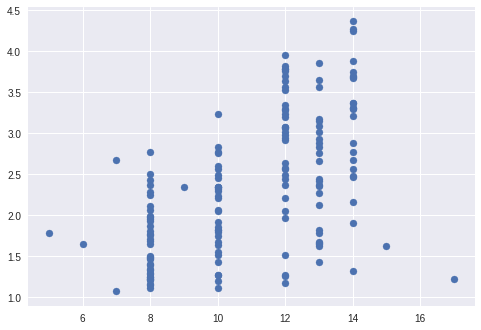

In [0]:
#another look
plt.scatter(modern_hits['age'],modern_hits['weight']);

In [0]:
#how is age spread out? nothing surprising
modern_hits['age'].value_counts().sort_index()

5.0      1
6.0      1
7.0      2
8.0     37
9.0      1
10.0    32
12.0    34
13.0    25
14.0    23
15.0     1
17.0     1
Name: age, dtype: int64

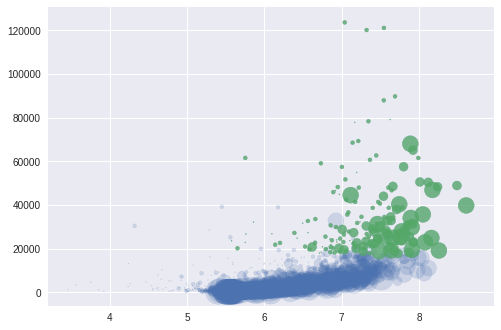

In [0]:
#playing with some visualizations
plt.scatter(x=games['bayes_rating'],y=games['owned'],s=games['weight_rnd']**4, alpha=.2)
plt.scatter(x=modern_hits['bayes_rating'],y=modern_hits['owned'],s=modern_hits['weight_rnd']**4,alpha=.75);

In [0]:
#Looking at top 5 percent, all games, and top 1 percent
top5perc.describe()

owned  bayes_rating      weight  avg_play_time         age  \
count     723.000000    723.000000  723.000000     723.000000  723.000000   
mean    14576.554633      6.927287    2.382605      77.304288   11.161826   
std     14296.074089      0.503473    0.782473      67.536315    2.380108   
min      5121.000000      5.272000    1.023300       2.000000    4.000000   
25%      6790.500000      6.611760    1.778550      30.000000   10.000000   
50%      9357.000000      6.934520    2.330500      60.000000   12.000000   
75%     16242.500000      7.258050    2.909750     100.000000   13.000000   
max    123608.000000      8.611030    4.516100    1000.000000   18.000000   

       best_with_dense    spinoffs  lang_dependance  comment_count  \
count       723.000000  723.000000       723.000000     723.000000   
mean          3.622407    1.199170         2.284924    2118.842324   
std           1.402371    3.482707         1.227177    1937.849654   
min           1.000000   -1.000000         1.000000     184.000000   
25%           3.000000    0.000000         1.000000     961.500000   
50%           4.000000    0.000000         2.000000    1503.000000   
75%           4.000000    1.000000         3.000000    2547.500000   
max          15.000000   34.000000         5.000000   16207.000000   

       honor_count  publish_date    best_age  max_play_time  min_play_time  \
count   723.000000    723.000000  722.000000     722.000000     723.000000   
mean      4.952974   2010.193638    6.074792      77.328255      55.343015   
std       5.527870      6.024522    1.209051      67.580057      41.569335   
min       0.000000   1991.000000    1.000000       2.000000       2.000000   
25%       1.000000   2007.000000    5.000000      30.000000      30.000000   
50%       3.000000   2012.000000    6.000000      60.000000      45.000000   
75%       7.000000   2015.000000    7.000000     100.000000      60.000000   
max      50.000000   2019.000000   10.000000    1000.000000     480.000000   

       play_time_range  max_players  min_players  player_range  rating_votes  \
count       722.000000   723.000000   723.000000    723.000000    723.000000   
mean         21.991690     5.354080     1.970954      3.383126  10191.305671   
std          49.905124     6.909121     0.702577      6.849477  10509.760999   
min           0.000000     1.000000     1.000000      0.000000   1367.000000   
25%           0.000000     4.000000     2.000000      2.000000   4293.500000   
50%           0.000000     4.000000     2.000000      3.000000   6566.000000   
75%          30.000000     6.000000     2.000000      4.000000  11889.500000   
max         995.000000   100.000000     8.000000     99.000000  84363.000000   

       weight_votes      trading      wanting       wishing      rating  \
count    723.000000   723.000000   723.000000    723.000000  723.000000   
mean     603.366528   321.578147   424.408022   2271.791148    7.245876   
std      765.963870   269.809290   344.697568   1988.099472    0.537839   
min       13.000000    21.000000     7.000000     85.000000    5.218980   
25%      167.000000   151.000000   168.000000    911.500000    6.921060   
50%      373.000000   249.000000   323.000000   1658.000000    7.269000   
75%      724.500000   399.500000   589.500000   2918.000000    7.596670   
max     6924.000000  2223.000000  2080.000000  13136.000000    8.906020   

          std_dev  weight_rnd  mechanic_count  designer_count  artist_count  \
count  723.000000  723.000000      723.000000      723.000000    723.000000   
mean     1.357623    2.373444        3.954357        1.484094      3.914246   
std      0.174665    0.856109        1.815406        0.850751     19.619111   
min      1.047930    1.000000        0.000000        0.000000      0.000000   
25%      1.227255    2.000000        3.000000        1.000000      1.000000   
50%      1.326840    2.000000        4.000000        1.000000      2.000000   
75%      1.468740    3.000000        

In [0]:
modern_games.describe()

id          owned  bayes_rating        weight  \
count   14475.000000   14475.000000  14475.000000  14179.000000   
mean   100721.481658    1337.253264      5.724553      2.031304   
std     83487.876443    4488.362464      0.395955      0.796337   
min         3.000000       3.000000      4.603830      1.000000   
25%     18400.500000     144.000000      5.516610      1.357100   
50%     92777.000000     308.000000      5.565520      2.000000   
75%    174247.500000     865.500000      5.738265      2.555600   
max    272409.000000  123608.000000      8.611030      5.000000   

       avg_play_time           age  best_with_dense      spinoffs  \
count   14119.000000  13528.000000     14475.000000  14475.000000   
mean       90.323182     10.238247         2.733955      0.381831   
std      1061.460960      2.735515         1.793900      1.920318   
min         1.000000      1.000000         0.000000     -1.000000   
25%        30.000000      8.000000         2.000000      0.000000   
50%        45.000000     10.000000         3.000000      0.000000   
75%        90.000000     12.000000         4.000000      0.000000   
max    120000.000000     25.000000        18.000000     34.000000   

       lang_dependance  comment_count   honor_count  publish_date  \
count     10553.000000   14475.000000  14475.000000  14475.000000   
mean          2.056856     210.287461      0.549361   2009.199724   
std           1.219778     637.000156      1.825682      7.188819   
min           1.000000       1.000000      0.000000   1991.000000   
25%           1.000000      24.000000      0.000000   2005.000000   
50%           2.000000      50.000000      0.000000   2011.000000   
75%           3.000000     138.000000      0.000000   2015.000000   
max           5.000000   16207.000000     50.000000   2020.000000   

           best_age  max_play_time  min_play_time  play_time_range  \
count  10452.000000   14041.000000   14104.000000     14026.000000   
mean       5.693264      90.617050      61.764039        28.762299   
std        1.670968    1064.396256     188.230361      1043.165158   
min        1.000000       1.000000       1.000000         0.000000   
25%        5.000000      30.000000      20.000000         0.000000   
50%        6.000000      45.000000      30.000000         0.000000   
75%        7.000000      90.000000      60.000000        10.000000   
max       11.000000  120000.000000   17280.000000    119880.000000   

        max_players   min_players  player_range  rating_votes  weight_votes  \
count  14346.000000  14442.000000  14336.000000  14475.000000  14475.000000   
mean       5.725777      2.056571      3.674037    826.654093     54.616028   
std       16.730257      0.674646     16.697100   3227.962129    217.576682   
min        1.000000      1.000000      0.000000     30.000000      0.000000   
25%        4.000000      2.000000      2.000000     56.000000      4.000000   
50%        4.000000      2.000000      2.000000    125.000000     10.000000   
75%        6.000000      2.000000      4.000000    404.000000     29.000000   
max      999.000000      9.000000    997.000000  84363.000000   6924.000000   

            trading       wanting      wishing        rating       std_dev  \
count  14475.000000  14475.000000  14475.00000  14475.000000  14475.000000   
mean      43.905976     47.650777    221.69361      6.436590      1.498422   
std       97.308105    127.325294    680.85157      0.905562      0.283940   
min        0.000000      0.000000      0.00000      1.052540      0.219673   
25%        5.000000      3.000000     14.00000      5.864590      1.301865   
50%       14.000000     10.000000     41.00000      6.463330      1.455740   
75%       41.000000     33.000000    135.00000      7.042875      1.641395   
max     2223.000000   2080.000000  13136.00000      9.597140      4.068800   

         weight_rnd  mechanic_count  designer_count  artist_count  \
count  14179.000000    14475.000000    10947.000000   5

In [0]:
modern_hits.describe()

id          owned  bayes_rating      weight  avg_play_time  \
count     144.000000     144.000000    144.000000  144.000000     144.000000   
mean    86450.444444   36214.381944      7.247983    2.354591      74.875000   
std     68767.231669   19806.562321      0.563894    0.818077      61.066383   
min        11.000000   19103.000000      5.576310    1.068500      10.000000   
25%     14482.500000   23034.750000      6.947253    1.672350      30.000000   
50%     97813.000000   28849.000000      7.298910    2.339200      60.000000   
75%    147252.250000   42789.750000      7.627990    2.938900      90.000000   
max    230802.000000  123608.000000      8.611030    4.264800     360.000000   

              age  best_with_dense    spinoffs  lang_dependance  \
count  144.000000       144.000000  144.000000       144.000000   
mean    11.020833         3.812500    2.500000         2.347222   
std      2.357754         1.300719    5.348028         1.253356   
min      5.000000         1.000000   -1.000000         1.000000   
25%      8.000000         3.000000    0.000000         1.000000   
50%     12.000000         4.000000    1.000000         2.000000   
75%     13.000000         4.000000    3.000000         3.250000   
max     17.000000         7.000000   34.000000         5.000000   

       comment_count  honor_count  publish_date    best_age  max_play_time  \
count     144.000000   144.000000    144.000000  144.000000     144.000000   
mean     4888.333333     9.937500   2008.972222    6.006944      74.875000   
std      2645.000097     8.540499      5.994105    1.173701      61.066383   
min      1824.000000     0.000000   1993.000000    4.000000      10.000000   
25%      2999.500000     3.000000   2005.000000    5.000000      30.000000   
50%      4050.500000     8.000000   2011.000000    6.000000      60.000000   
75%      5695.750000    13.000000   2014.000000    7.000000      90.000000   
max     16207.000000    50.000000   2017.000000    9.000000     360.000000   

       min_play_time  play_time_range  max_players  min_players  player_range  \
count     144.000000       144.000000   144.000000   144.000000    144.000000   
mean       49.250000        25.625000     5.951389     2.013889      3.937500   
std        32.027414        41.719489     8.299743     0.719228      8.227719   
min         5.000000         0.000000     1.000000     1.000000      0.000000   
25%        30.000000         0.000000     4.000000     2.000000      2.000000   
50%        45.000000         0.000000     5.000000     2.000000      3.000000   
75%        60.000000        30.000000     6.000000     2.000000      4.000000   
max       180.000000       240.000000    99.000000     5.000000     97.000000   

       rating_votes  weight_votes      trading      wanting       wishing  \
count    144.000000    144.000000   144.000000   144.000000    144.000000   
mean   25910.291667   1512.381944   651.513889   686.826389   4516.777778   
std    14366.420118   1242.141795   385.467149   451.419553   2670.481501   
min    11165.000000    138.000000   110.000000    38.000000    410.000000   
25%    16828.750000    716.000000   410.750000   310.250000   2491.250000   
50%    21133.500000   1192.000000   560.000000   587.000000   4423.000000   
75%    30231.250000   1858.000000   778.250000   976.000000   6164.500000   
max    84363.000000   6924.000000  2223.000000  2080.000000  13136.000000   

           rating     std_dev  weight_rnd  mechanic_count  designer_count  \
count  144.000000  144.000000  144.000000      144.000000      144.000000   
mean     7.400715    1.376231    2.340278        4.333333        1.423611   
std      0.578746    0.181138    0.909647        2.003493        0.912844   
min      5.683840    1.102910    1.000000        1.000000        1.000000   
25%      7.078980    1.245300    2.000000        3.000000        1.000000   
50%      7.438465    1.356185    2.000000        4.000000        1.000000   
75%      7.767490    1.4680

In [0]:
#27x multiplier on "sales"
modern_hits['owned'].mean()/modern_games['owned'].mean()

27.081169223984208

In [0]:
#magic the gathering throws off the artist count so cut it for a moment
print(modern_hits[modern_hits['artist_count'] != 509]['artist_count'].mean())
print(games[games['artist_count'] != 509]['artist_count'].mean())

4.685314685314685
2.110900637162046


In [0]:
#knowing CaH's story, not surprising, but 8 is still a lot of people on one game
#the other 2 have a lot in them so it makes sense they would bring in others
modern_hits[modern_hits['designer_count'] > 4]

id                           name  owned  bayes_rating  weight  \
36  10547  Betrayal at House on the Hill  45848       6.89175  2.3692   
88  50381         Cards Against Humanity  32134       5.86006  1.2205   
59  39463               Cosmic Encounter  28922       7.40041  2.5667   

    avg_play_time   age  best_with_dense  spinoffs  lang_dependance  \
36           60.0  12.0                5         0              4.0   
88           30.0  17.0                6         0              4.0   
59          120.0  12.0                5         3              4.0   

    comment_count  honor_count  publish_date  best_age  max_play_time  \
36           6685          2.0          2004       7.0           60.0   
88           3862          0.0          2009       9.0           30.0   
59           5002          2.0          2008       7.0          120.0   

    min_play_time  play_time_range  max_players  min_players best_with  \
36           60.0              0.0          6.0          3.0       5.0   
88           30.0              0.0         30.0          4.0       6.0   
59           60.0             60.0          5.0          3.0       5.0   

    player_range  rating_votes  weight_votes  trading  wanting  wishing  \
36           3.0         30074          1655      947      547     4733   
88          26.0         19257           753      503       66     1065   
59           2.0         23800          1184      537     1183     6744   

     rating  std_dev  weight_rnd  \
36  7.08311  1.56036         2.0   
88  6.02847  2.07043         1.0   
59  7.55756  1.70588         3.0   

                                          description  \
36  From the press release:<br/><br/>Betrayal at H...   
88  &quot;A party game for horrible people.&quot;<...   
59  From the Manufacturer<br/><br/>Build a galacti...   

                                                image  mechanic_count  \
36  https://cf.geekdo-images.com/original/img/0Rb-...               9   
88  https://cf.geekdo-images.com/original/img/jg6r...               2   
59  https://cf.geekdo-images.com/original/img/gOe4...               6   

    designer_count  artist_count  category_count  subdomain_count  \
36             5.0           3.0               4                1   
88             8.0           0.0               5                1   
59             5.0           7.0               4                2   

    publisher_count  
36                3  
88                2  
59                7

In [0]:
#looking at the top 1% by rating vs the top 1% by owned
top_rated_games.describe()

id          owned  bayes_rating      weight  avg_play_time  \
count     144.000000     144.000000    144.000000  144.000000     144.000000   
mean   123479.493056   24522.777778      7.625352    3.096244     120.381944   
std     73613.348959   19407.850674      0.256411    0.718065     102.026803   
min        12.000000    4102.000000      7.327830    1.304300      15.000000   
25%     43087.000000   10981.500000      7.415985    2.564025      60.000000   
50%    145377.000000   17806.500000      7.556880    3.203550     120.000000   
75%    178027.000000   31218.750000      7.789465    3.690700     120.000000   
max    266192.000000  121076.000000      8.611030    4.516100    1000.000000   

              age  best_with_dense    spinoffs  lang_dependance  \
count  144.000000       144.000000  144.000000       144.000000   
mean    12.284722         3.465278    1.111111         2.500000   
std      1.815486         1.133799    2.904328         1.268224   
min      8.000000         1.000000   -1.000000         1.000000   
25%     12.000000         3.000000    0.000000         1.000000   
50%     12.000000         4.000000    0.000000         3.000000   
75%     14.000000         4.000000    1.000000         4.000000   
max     17.000000         8.000000   21.000000         5.000000   

       comment_count  honor_count  publish_date    best_age  max_play_time  \
count     144.000000   144.000000    144.000000  144.000000     144.000000   
mean     3355.215278     9.256944   2011.993056    6.847222     120.381944   
std      2570.688317     8.042498      5.144753    1.019526     102.026803   
min       570.000000     0.000000   1991.000000    4.000000      15.000000   
25%      1465.500000     4.000000   2009.000000    6.000000      60.000000   
50%      2596.000000     7.000000   2014.000000    7.000000     120.000000   
75%      4449.250000    12.000000   2016.000000    8.000000     120.000000   
max     13977.000000    50.000000   2019.000000   10.000000    1000.000000   

       min_play_time  play_time_range  max_players  min_players  player_range  \
count     144.000000       144.000000   144.000000   144.000000    144.000000   
mean       71.666667        48.715278     4.402778     1.812500      2.590278   
std        52.556995        91.656753     1.302603     0.647413      1.329668   
min         5.000000         0.000000     2.000000     1.000000      0.000000   
25%        40.000000         0.000000     4.000000     1.000000      2.000000   
50%        60.000000        30.000000     4.000000     2.000000      3.000000   
75%        90.000000        60.000000     5.000000     2.000000      3.000000   
max       480.000000       995.000000    10.000000     5.000000      7.000000   

       rating_votes  weight_votes      trading      wanting       wishing  \
count    144.000000    144.000000   144.000000   144.000000    144.000000   
mean   18303.638889   1063.354167   347.944444   880.305556   4899.083333   
std    14558.944606   1105.627363   326.295027   371.238737   2423.418828   
min     2409.000000     75.000000    22.000000   231.000000    821.000000   
25%     8239.250000    333.750000   131.500000   616.750000   3030.250000   
50%    15076.000000    727.000000   247.000000   820.000000   4655.500000   
75%    23773.750000   1321.250000   477.000000  1119.250000   6406.750000   
max    82331.000000   5760.000000  1935.000000  2080.000000  13136.000000   

           rating     std_dev  weight_rnd  mechanic_count  designer_count  \
count  144.000000  144.000000  144.000000      144.000000      144.000000   
mean     7.923037    1.380958    3.083333        4.673611        1.527778   
std      0.299089    0.160168    0.770977        2.081654        0.844103   
min      7.448320    1.098460    1.000000        1.000000        1.000000   
25%      7.700607    1.262950    3.000000        3.000000        1.000000   
50%      7.861240    1.363040    3.000000        4.000000        1.000000   
75%      8.101118    1.4802

In [0]:
modern_hits.describe()

owned  bayes_rating      weight  avg_play_time         age  \
count     144.000000    144.000000  144.000000     144.000000  144.000000   
mean    36214.381944      7.247983    2.354591      74.875000   11.020833   
std     19806.562321      0.563894    0.818077      61.066383    2.357754   
min     19103.000000      5.576310    1.068500      10.000000    5.000000   
25%     23034.750000      6.947253    1.672350      30.000000    8.000000   
50%     28849.000000      7.298910    2.339200      60.000000   12.000000   
75%     42789.750000      7.627990    2.938900      90.000000   13.000000   
max    123608.000000      8.611030    4.264800     360.000000   17.000000   

       best_with_dense    spinoffs  lang_dependance  comment_count  \
count       144.000000  144.000000       144.000000     144.000000   
mean          3.812500    2.500000         2.347222    4888.333333   
std           1.300719    5.348028         1.253356    2645.000097   
min           1.000000   -1.000000         1.000000    1824.000000   
25%           3.000000    0.000000         1.000000    2999.500000   
50%           4.000000    1.000000         2.000000    4050.500000   
75%           4.000000    3.000000         3.250000    5695.750000   
max           7.000000   34.000000         5.000000   16207.000000   

       honor_count  publish_date    best_age  max_play_time  min_play_time  \
count   144.000000    144.000000  144.000000     144.000000     144.000000   
mean      9.937500   2008.972222    6.006944      74.875000      49.250000   
std       8.540499      5.994105    1.173701      61.066383      32.027414   
min       0.000000   1993.000000    4.000000      10.000000       5.000000   
25%       3.000000   2005.000000    5.000000      30.000000      30.000000   
50%       8.000000   2011.000000    6.000000      60.000000      45.000000   
75%      13.000000   2014.000000    7.000000      90.000000      60.000000   
max      50.000000   2017.000000    9.000000     360.000000     180.000000   

       play_time_range  max_players  min_players  player_range  rating_votes  \
count       144.000000   144.000000   144.000000    144.000000    144.000000   
mean         25.625000     5.951389     2.013889      3.937500  25910.291667   
std          41.719489     8.299743     0.719228      8.227719  14366.420118   
min           0.000000     1.000000     1.000000      0.000000  11165.000000   
25%           0.000000     4.000000     2.000000      2.000000  16828.750000   
50%           0.000000     5.000000     2.000000      3.000000  21133.500000   
75%          30.000000     6.000000     2.000000      4.000000  30231.250000   
max         240.000000    99.000000     5.000000     97.000000  84363.000000   

       weight_votes      trading      wanting       wishing      rating  \
count    144.000000   144.000000   144.000000    144.000000  144.000000   
mean    1512.381944   651.513889   686.826389   4516.777778    7.400715   
std     1242.141795   385.467149   451.419553   2670.481501    0.578746   
min      138.000000   110.000000    38.000000    410.000000    5.683840   
25%      716.000000   410.750000   310.250000   2491.250000    7.078980   
50%     1192.000000   560.000000   587.000000   4423.000000    7.438465   
75%     1858.000000   778.250000   976.000000   6164.500000    7.767490   
max     6924.000000  2223.000000  2080.000000  13136.000000    8.906020   

          std_dev  weight_rnd  mechanic_count  designer_count  artist_count  \
count  144.000000  144.000000      144.000000      144.000000    144.000000   
mean     1.376231    2.340278        4.333333        1.423611      8.187500   
std      0.181138    0.909647        2.003493        0.912844     42.666862   
min      1.102910    1.000000        1.000000        1.000000      0.000000   
25%      1.245300    2.000000        3.000000        1.000000      1.000000   
50%      1.356185    2.000000        4.000000        1.000000      3.000000   
75%      1.468058    3.000000        

##Visuals for Blog

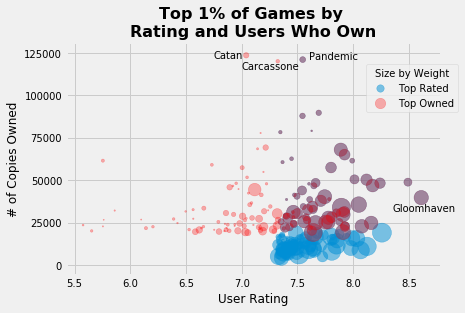

In [0]:
#Set a style sheet and instantiate fig and ax
plt.style.use('fivethirtyeight')
fig,ax = plt.subplots()

#set our basic labels
ax.set_title(label='Top 1% of Games by \nRating and Users Who Own', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('User Rating', fontsize=12)
ax.set_ylabel('# of Copies Owned', fontsize=12)

#label some outliers
ax.text(x=6.75, y=122000, s='Catan', fontsize=10)
ax.text(x=7.00, y=115500, s='Carcassone', fontsize=10)
ax.text(x=7.60, y=121000, s='Pandemic', fontsize=10)
ax.text(x=8.35, y=31500, s='Gloomhaven', fontsize=10)

#Edit tick details
ax.set(yticks=range(0,130000,25000))
ax.tick_params(axis='both', which='major', labelsize=10)

#plot the data
plt.scatter(x=top_rated_games['bayes_rating'],
            y=top_rated_games['owned'],
            s=top_rated_games['weight']**4, alpha=.5, label='Top Rated')
plt.scatter(x=modern_hits['bayes_rating'],
            y=modern_hits['owned'],
            s=modern_hits['weight']**4,color = 'red', 
            alpha=.3, label='Top Owned');

#Create and tweak details of the legend
lgnd = plt.legend(loc=(.8,.7),scatterpoints=1, fontsize=10, 
                  title_fontsize=10, title='Size by Weight')
lgnd.legendHandles[0]._sizes = [55]
lgnd.legendHandles[1]._sizes = [110]

#Save
plt.savefig('Games_by_rating_and_owned.png', format='png', 
            dpi=300, bbox_inches='tight')
files.download('Games_by_rating_and_owned.png')

In [0]:
#confirming I'm labeling the right games
modern_hits.head(5)

name   owned  bayes_rating  weight  avg_play_time   age  \
id                                                                      
13           Catan  123608       7.04016  2.3412          120.0  10.0   
30549     Pandemic  121076       7.54713  2.4230           45.0   8.0   
822    Carcassonne  120110       7.32325  1.9259           45.0   8.0   
68448    7 Wonders   89740       7.69094  2.3406           30.0  10.0   
36218     Dominion   87899       7.54537  2.3632           30.0  13.0   

       best_with_dense  spinoffs  lang_dependance  comment_count  honor_count  \
id                                                                              
13                   4        31              2.0          16207         13.0   
30549                4         8              2.0          13977         34.0   
822                  2        25              1.0          16078         12.0   
68448                4         1              1.0          11723         50.0   
36218                3         8              3.0          12115         41.0   

       publish_date  best_age  max_play_time  min_play_time  play_time_range  \
id                                                                             
13             1995       5.0          120.0           60.0             60.0   
30549          2008       6.0           45.0           45.0              0.0   
822            2000       5.0           45.0           30.0             15.0   
68448          2010       6.0           30.0           30.0              0.0   
36218          2008       6.0           30.0           30.0              0.0   

       max_players  min_players best_with  player_range  rating_votes  \
id                                                                      
13             4.0          3.0       4.0           1.0         84363   
30549          4.0          2.0       4.0           2.0         82331   
822            5.0          2.0       2.0           3.0         84045   
68448          7.0          2.0       4.0           5.0         68249   
36218          4.0          2.0       3.0           2.0         67698   

       weight_votes  trading  wanting  wishing   rating  std_dev  weight_rnd  \
id                                                                             
13             6844     1652      451     4699  7.19430  1.46985         2.0   
30549          4854     1935      622     7610  7.64064  1.32187         2.0   
822            6924     1461      498     5337  7.42741  1.30276         2.0   
68448          3984     1144     1025     9407  7.78348  1.27550         2.0   
36218          4669     1791      564     6621  7.64685  1.42680         2.0   

                                             description  \
id                                                         
13     In Catan (formerly The Settlers of Catan), pla...   
30549  In Pandemic, several virulent diseases have br...   
822    Carcassonne is a tile-placement game in which ...   
68448  You are the leader of one of the 7 great citie...   
36218  (from the back of the box:)<br/><br/>&quot;You...   

                                                   image  mechanic_count  \
id                                                                         
13     https://cf.geekdo-images.com/original/img/A-0y...               4   
30549  https://cf.geekdo-images.com/original/img/j-pf...               7   
822    https://cf.geekdo-images.com/original/img/o4p6...               2   
68448  https://cf.geekdo-images.com/original/img/3DP_...               5   
36218  https://cf.geekdo-images.com/original/img/oN8C...               3   

       designer_count  artist_count  category_count  subdomain_count  \
id                                                                     
13                1.0          11.0               1                2   
30549             1.0           5.0               1                2   
822               1.0           4.0               3       

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


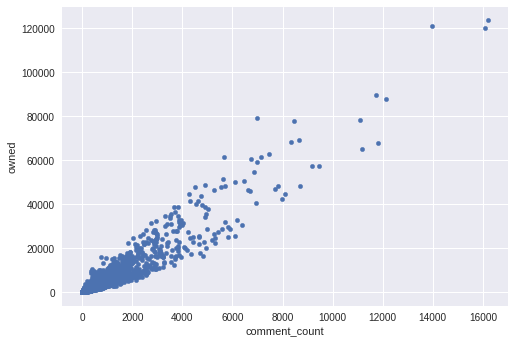

In [0]:
#The more people that own it, the more people that want to talk about it
#A last minute hunch that went nowhere
modern_games.plot.scatter(x='comment_count', y='owned')

In [0]:
#deciding whether to label a low ranking outlier or not, decided not to
#interesting to see common games at Target at the bottom of the barrel
#relying on uninformed purchases as presents? or the gimmick?
modern_games.sort_values(by='bayes_rating').head(5)

name  owned  bayes_rating  weight  \
id                                                                           
3510                      Battle of the Sexes   1795       4.60383  1.0857   
205322             The Oregon Trail Card Game   5097       4.79258  1.2069   
5050    The Worst-Case Scenario Survival Game    992       4.82822  1.2000   
3990                             Fact or Crap   1344       4.97508  1.2059   
12205                             In a Pickle   2878       5.07081  1.2093   

        avg_play_time   age  best_with_dense  spinoffs  lang_dependance  \
id                                                                        
3510             45.0  12.0                6         4              5.0   
205322           45.0  12.0                6         0              4.0   
5050             40.0   8.0                3         0              5.0   
3990             30.0  12.0                6         0              5.0   
12205            20.0  10.0                5         0              5.0   

        comment_count  honor_count  publish_date  best_age  max_play_time  \
id                                                                          
3510              410          0.0          1997       5.0           45.0   
205322            532          0.0          2016       5.0           45.0   
5050              223          0.0          2002       NaN           40.0   
3990              220          0.0          2001       7.0           30.0   
12205             400          0.0          2004       5.0           20.0   

        min_play_time  play_time_range  max_players  min_players best_with  \
id                                                                           
3510             45.0              0.0          8.0          2.0       6.0   
205322           30.0             15.0          6.0          2.0       6.0   
5050             20.0             20.0         10.0          2.0       3.0   
3990             30.0              0.0          8.0          3.0       6.0   
12205            20.0              0.0          6.0          2.0         5   

        player_range  rating_votes  weight_votes  trading  wanting  wishing  \
id                                                                            
3510             6.0          1007            70      161        3       19   
205322           4.0          1916            29      242        9      118   
5050             8.0           538            45       80        2       10   
3990             5.0           588            34      115        2       11   
12205            4.0          1227            86      232        5       38   

         rating  std_dev  weight_rnd  \
id                                     
3510    3.47882  1.69444         1.0   
205322  4.38501  1.89229         1.0   
5050    3.27530  1.76159         1.0   
3990    3.84491  1.64655         1.0   
12205   4.68711  1.67220         1.0   

                                              description  \
id                                                          
3510    Players divide into two teams: men vs. women. ...   
205322  Description from the publisher:<br/><br/>&quot...   
5050    Publisher's Description:<br/><br/>Do you know ...   
3990    Basic trivia game where players try to figure ...   
12205   Does a sofa fit in a shopping cart? It all dep...   

                                                    image  mechanic_count  \
id                                                                          
3510    https://cf.geekdo-images.com/original/img/Oo4v...               1   
205322  https://cf.geekdo-images.com/original/img/FxY9...               2   
5050    https://cf.geekdo-images.com/original/img/Ekih...               0   
3990    https://cf.geekdo-images.com/original/img/3m1Q...               2   
12205   https://cf.geekdo-images.com/original/img/fE29...               2   

        designer_count  artist_count  category_count  subdomain_count  \
id   

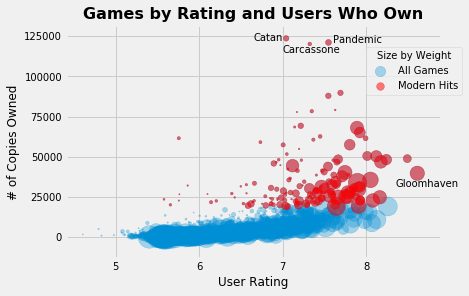

In [0]:
#Set a style sheet and instantiate fig and ax
plt.style.use('fivethirtyeight')
fig,ax = plt.subplots()

#set our basic labels
ax.set_title(label='Games by Rating and Users Who Own', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('User Rating', fontsize=12)
ax.set_ylabel('# of Copies Owned', fontsize=12)

#label some outliers
ax.text(x=6.65, y=122000, s='Catan', fontsize=10)
ax.text(x=7.00, y=114500, s='Carcassone', fontsize=10)
ax.text(x=7.60, y=121000, s='Pandemic', fontsize=10)
ax.text(x=8.35, y=31500, s='Gloomhaven', fontsize=10)

#Edit tick details
ax.set(yticks=range(0,130000,25000))
ax.tick_params(axis='both', which='major', labelsize=10)

#plot the data
plt.scatter(x=modern_games['bayes_rating'], y=modern_games['owned'],
            s=modern_games['weight']**4, alpha=.33, label='All Games')
plt.scatter(x=modern_hits['bayes_rating'], y=modern_hits['owned'],
            s=modern_hits['weight']**4, color ='red',
            alpha=.5, label='Modern Hits');

#Create and tweak details of the legend
lgnd = plt.legend(loc=(.8,.7),scatterpoints=1, fontsize=10, 
                  title_fontsize=10, title='Size by Weight')
lgnd.legendHandles[0]._sizes = [110]
lgnd.legendHandles[1]._sizes = [60]

#Save
plt.savefig('Games_by_rating_and_owned_all.png', format='png', 
            dpi=300, bbox_inches='tight')
files.download('Games_by_rating_and_owned_all.png')

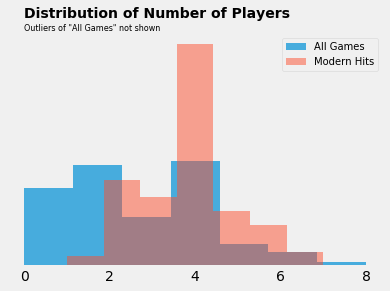

In [0]:
#Set a style sheet and instantiate fig and ax
plt.style.use('fivethirtyeight')
fig,ax = plt.subplots()

#Put a title on it
ax.text(x=0, y=.58, s='Distribution of Number of Players', 
        fontsize=14, fontweight='bold')
ax.text(x=0, y=.55, s='Outliers of "All Games" not shown', fontsize=8)

#get rid of grid lines and y-ticks
ax.set(yticks=[])
ax.grid(b=False, axis='x')

#plot
plt.hist(modern_games[modern_games['best_with_dense'] <= 8]['best_with_dense'], 
         density=True, alpha=.7,bins=7, label='All Games');
plt.hist(modern_hits['best_with_dense'], density=True, 
         bins=7, alpha=.5, label='Modern Hits');


#legend
plt.legend(fontsize=10);

#save
plt.savefig('distribution_of_number_of_players.png', format='png', 
            dpi=300, bbox_inches='tight')
files.download('distribution_of_number_of_players.png')

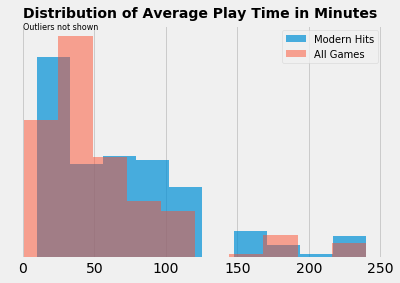

In [0]:
#Set a style sheet and instantiate fig and ax
plt.style.use('fivethirtyeight')
fig,ax = plt.subplots()

#Put a title on it
ax.text(x=0, y=.0165, s='Distribution of Average Play Time in Minutes', 
        fontsize=14, fontweight='bold')
ax.text(x=0, y=.0157, s='Outliers not shown', fontsize=8)

#get rid y-ticks
ax.set(yticks=[])

#plot
plt.hist(modern_hits[modern_hits['avg_play_time']<=240]['avg_play_time'], 
         density=True, alpha=.7, label='Modern Hits');
plt.hist(modern_games[modern_games['avg_play_time']<=240]['avg_play_time'], 
         density=True, alpha=.5, label='All Games');

#legend
plt.legend(fontsize=10);

#save
plt.savefig('distribution_of_play_time.png', format='png', 
            dpi=300, bbox_inches='tight')
files.download('distribution_of_play_time.png')


In [0]:
# modern_hits.groupby('best_with_dense')['id'].count()/len(modern_hits)

best_with_dense
1    0.020833
2    0.173611
3    0.138889
4    0.444444
5    0.111111
6    0.083333
7    0.027778
Name: id, dtype: float64

In [0]:
modern_games.groupby('best_with_dense')['id'].count()/len(modern_games)

best_with_dense
0     0.172366
1     0.034819
2     0.268739
3     0.132366
4     0.280415
5     0.058307
6     0.039033
7     0.005181
8     0.005665
9     0.000622
10    0.001105
11    0.000138
12    0.000415
13    0.000138
14    0.000138
15    0.000276
16    0.000207
18    0.000069
Name: id, dtype: float64

In [0]:
#Catan, Carcassone, and Pandemic are rediculous
modern_hits.head(3)['owned'].mean()

121598.0

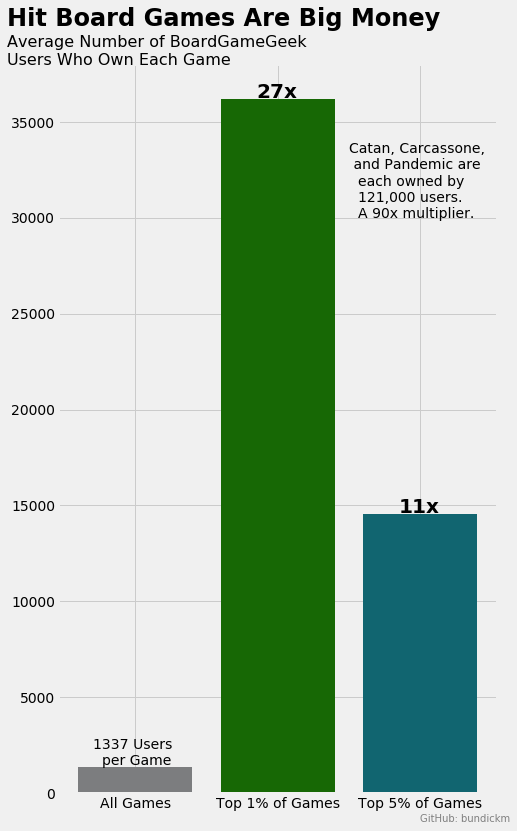

In [9]:
#set style and instantiate fig and ax
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(7,12.5))

#Title
ax.text(x=-.9, y=40000, s='Hit Board Games Are Big Money', 
        fontweight='bold', fontsize=24)
ax.text(x=-.9, y=38000, 
        s='Average Number of BoardGameGeek\nUsers Who Own Each Game', fontsize=16)

#bar flavor text
ax.text(x=-.3, y=1450, s='1337 Users\n  per Game')
ax.text(x=.85, y=36250, s='27x', fontsize=20, fontweight='bold')
ax.text(x=1.85, y=14600, s='11x', fontsize=20, fontweight='bold')

#fun fact, these three are stupid big
ax.text(x=1.5, y=30000, 
        s='Catan, Carcassone,\n and Pandemic are\n  each owned by\n  121,000 users.\n  A 90x multiplier.')

#watermark
ax.text(x=2, y=-1500, s='GitHub: bundickm', fontsize=10, color='grey')

#Plot it, spent too much time on colors
plt.bar(['All Games','Top 1% of Games', 'Top 5% of Games'],
        [modern_games['owned'].mean(),modern_hits['owned'].mean(),
         top5perc['owned'].mean()],color=['#7c7d7f','#176805','#116570']);

#save
plt.savefig('average_owned.png', format='png', dpi=300, bbox_inches='tight')
files.download('average_owned.png')

In [0]:
#this is not the best way to go about this, just bashing it together
summary_table = pd.DataFrame(index=['Modern Hits','Top Rated'])
summary_table['Rating'] = [modern_hits['bayes_rating'].mean(), 
                           top_rated_games['bayes_rating'].mean()]
summary_table['Weight'] = [modern_hits['weight'].mean(), 
                           top_rated_games['weight'].mean()]
summary_table['Play Time'] = [modern_hits['avg_play_time'].mean(), 
                           top_rated_games['avg_play_time'].mean()]
summary_table

Rating    Weight   Play Time
Modern Hits  7.247983  2.354591   74.875000
Top Rated    7.625352  3.096244  120.381944

###Signifigance Testing
Confirming my claims aren't nonsense

In [0]:
from scipy import stats

In [0]:
#pull all numerical column names
columns = modern_hits.describe().columns
columns

Index(['owned', 'bayes_rating', 'weight', 'avg_play_time', 'age',
       'best_with_dense', 'spinoffs', 'lang_dependance', 'comment_count',
       'honor_count', 'publish_date', 'best_age', 'max_play_time',
       'min_play_time', 'play_time_range', 'max_players', 'min_players',
       'player_range', 'rating_votes', 'weight_votes', 'trading', 'wanting',
       'wishing', 'rating', 'std_dev', 'weight_rnd', 'mechanic_count',
       'designer_count', 'artist_count', 'category_count', 'subdomain_count',
       'publisher_count'],
      dtype='object')

In [0]:
#running 2 sample t-test to confirm differences are real
for column in columns:
  print(column)
  print(stats.ttest_ind(modern_hits[column],
                        modern_games[column], nan_policy='omit'))
  print()
#average play time has no statistically significant difference

owned
Ttest_indResult(statistic=85.39050574043141, pvalue=0.0)

bayes_rating
Ttest_indResult(statistic=45.71246397717452, pvalue=0.0)

weight
Ttest_indResult(statistic=4.845722440078303, pvalue=1.2747323987309541e-06)

avg_play_time
Ttest_indResult(statistic=-0.17463538022829023, pvalue=0.8613686253937015)

age
Ttest_indResult(statistic=3.4194811061261317, pvalue=0.0006292390163959325)

best_with_dense
Ttest_indResult(statistic=7.195840046996821, pvalue=6.509736020023815e-13)

spinoffs
Ttest_indResult(statistic=12.756196716135014, pvalue=4.5383225849641095e-37)

lang_dependance
Ttest_indResult(statistic=2.8362313382361224, pvalue=0.004573511681392283)

comment_count
Ttest_indResult(statistic=81.45827772423091, pvalue=0.0)

honor_count
Ttest_indResult(statistic=55.952279767046136, pvalue=0.0)

publish_date
Ttest_indResult(statistic=-0.3784484102435635, pvalue=0.7051030075137612)

best_age
Ttest_indResult(statistic=2.2450118283577427, pvalue=0.02478791759095697)

max_play_time
Ttest_indR